# Analyses
Dans ce notebook, nous allons faire une première analyse des données.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from ast import literal_eval

from constants import *

## Statistiques sur les données brutes

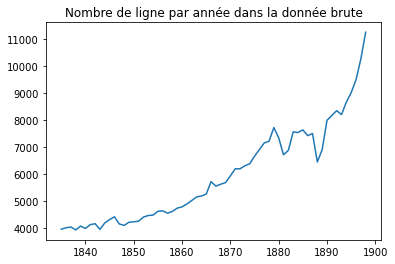

In [2]:
df_temp = pd.read_csv(ORGANIZED_RAW_DATA)
df_temp["count"] = 1
lines_per_year = df_temp[["count", "annee"]].groupby("annee").sum()

plt.plot(lines_per_year.index, lines_per_year.values)
plt.title("Nombre de ligne par année dans la donnée brute")
plt.show()

In [3]:
df_raw = pd.read_csv(ORGANIZED_RAW_DATA)
df_raw[["chef_vocation", "enfants_profession", "pensionnaires_condition", "profession"]] = df_raw[["chef_vocation", "enfants_profession", "pensionnaires_condition", "profession"]].applymap(literal_eval)
df_raw

chef_vocation enfants_profession pensionnaires_condition  annee  \
0          [rocureur]                 []      [pensre friere se]   1835   
1           [pintier]                 []                [pensre]   1835   
2         [boulanger]                 []               [ouvrier]   1835   
3         [voiturier]                 []                [penvre]   1835   
4          [marechat]                 []      [ouvrier, ouvrier]   1835   
...               ...                ...                     ...    ...   
378721       [chay l]                 []                      []   1898   
378722  [meme maison]                 []                      []   1898   
378723     [monimier]                 []                      []   1898   
378724   [ontumineur]                 []                      []   1898   
378725    [aman bure]                 []                      []   1898   

                          profession  
0       [rocureur, pensre friere se]  
1                  [pintier, pensre]  
2               [boulanger, ouvrier]  
3                [voiturier, penvre]  
4       [marechat, ouvrier, ouvrier]  
...                              ...  
378721                      [chay l]  
378722                 [meme maison]  
378723                    [monimier]  
378724                  [ontumineur]  
378725                   [aman bure]  

[378726 rows x 5 columns]

<AxesSubplot:title={'center':"Nombre d'occurrence de la donnée brute"}, xlabel='Annee', ylabel='Occurrences'>

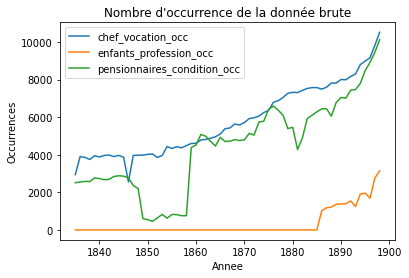

In [4]:
count_non_empty_string = lambda l: 0 if len(l)==1 and len(l[0])==0 else len(l)

df_raw["chef_vocation_occ"] = df_raw["chef_vocation"].apply(count_non_empty_string)
df_raw["enfants_profession_occ"] = df_raw["enfants_profession"].apply(count_non_empty_string)
df_raw["pensionnaires_condition_occ"] = df_raw["pensionnaires_condition"].apply(count_non_empty_string)
df_raw["profession_occ"] = df_raw["profession"].apply(count_non_empty_string)
df_occ = df_raw[["chef_vocation_occ", "enfants_profession_occ", "pensionnaires_condition_occ", "annee"]]
df_occ.groupby("annee").sum().plot(title="Nombre d'occurrence de la donnée brute", xlabel="Annee", ylabel="Occurrences")

In [5]:
df_job_occ = df_raw[["profession", "annee"]].explode("profession").copy()
df_job_occ = df_job_occ[~df_job_occ["profession"].isin({"·", ""})]
df_job_occ = df_job_occ.dropna()
df_job_occ["occ"] = 1 
df_job_occ

profession  annee  occ
0               rocureur   1835    1
0       pensre friere se   1835    1
1                pintier   1835    1
1                 pensre   1835    1
2              boulanger   1835    1
...                  ...    ...  ...
378721            chay l   1898    1
378722       meme maison   1898    1
378723          monimier   1898    1
378724        ontumineur   1898    1
378725         aman bure   1898    1

[641406 rows x 3 columns]

<AxesSubplot:title={'center':'Occurences des métiers par année avant nettoyage'}, xlabel='Annee'>

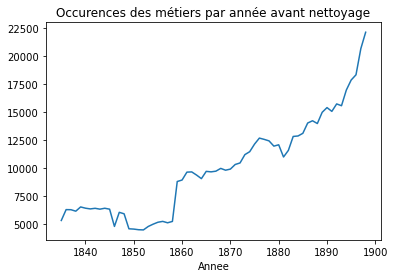

In [6]:
df_job_occ.groupby("annee")["occ"].sum().plot(title="Occurences des métiers par année avant nettoyage", xlabel="Annee")


In [17]:
df_selected_jobs_occ = pd.read_csv(SELECTED_JOB_COUNT, index_col=0)
df_selected_jobs_occ

profession  annee  occ
0           agent   1845    1
1           agent   1848    1
2           agent   1858   12
3           agent   1859    1
4           agent   1863    1
...           ...    ...  ...
10976  volontaire   1894   15
10977  volontaire   1895   40
10978  volontaire   1896   23
10979  volontaire   1897   15
10980  volontaire   1898   16

[10981 rows x 3 columns]

In [8]:
correct_terms = sorted(set(pd.read_csv(CORRECT_JOBS)["0"]))

<AxesSubplot:title={'center':'Occurences des métiers par année après séléction des occurrences nettoyées'}, xlabel='Annee'>

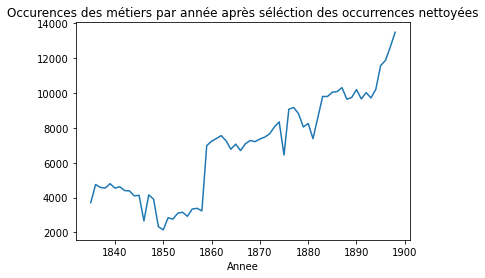

In [18]:
df_selected_jobs_occ.groupby("annee")["occ"].sum().plot(title="Occurences des métiers par année après séléction des occurrences nettoyées", xlabel="Annee")


<AxesSubplot:title={'center':"% d'occurrence des métiers gardées par année"}, xlabel='Annee'>

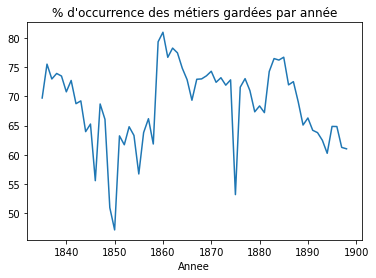

In [19]:
(df_selected_jobs_occ.groupby("annee")["occ"].sum() / df_job_occ.groupby("annee")["occ"].sum() * 100).plot(title="% d'occurrence des métiers gardées par année", xlabel="Annee")


## Analysis des données nettoyées

df_job_occ contient à partir de ce point les données corrigées dans un soucis de simplicité

In [21]:
df_selected_jobs_occ["profession"].nunique()

255

In [22]:
df_selected_jobs_occ.iloc[df_selected_jobs_occ[df_selected_jobs_occ["profession"] =="dque"].index, 0] = "domestique"
df_selected_jobs_occ = df_selected_jobs_occ.groupby(["profession", "annee"]).sum("occ").reset_index()

In [23]:
occ_per_job = df_selected_jobs_occ.groupby("profession")["occ"].sum()
occ_per_job

profession
agent                 31
agent de police      452
agriculteur        10411
aide                 557
apprenti            1896
                   ...  
vigneron            4784
vigneronne            40
vitrier              269
voiturier            911
volontaire           264
Name: occ, Length: 254, dtype: int64

### Evolution des métiers à travers les années
Afin de se concentrer sur les métiers avec suffisament de données nous gardons les métiers avec en moyenne plus de 15 occurrences par année.



In [24]:
def plot_evolution(df, job_name, col_name, plot_dir):
    data = df[df[col_name]==job_name]
    plt.plot(data["annee"], data["occ"])
    plt.title(job_name)
    plt.savefig(PLOT_DIR+ plot_dir +job_name + ".png")
    plt.show()

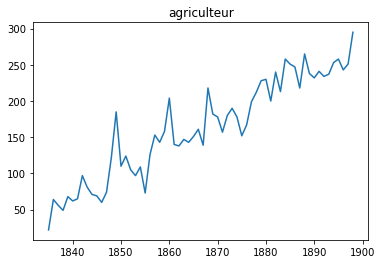

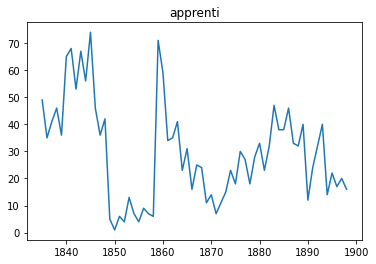

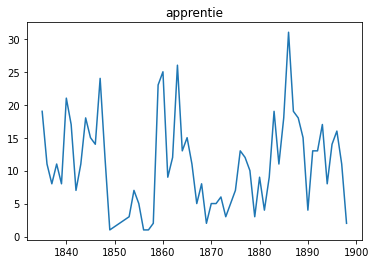

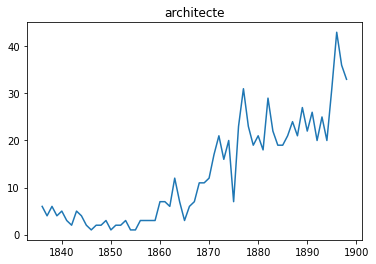

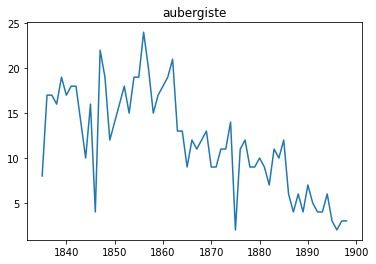

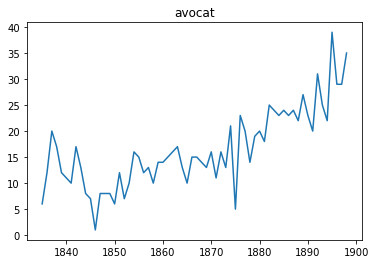

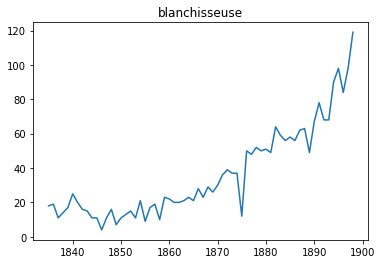

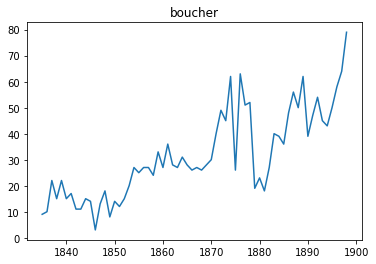

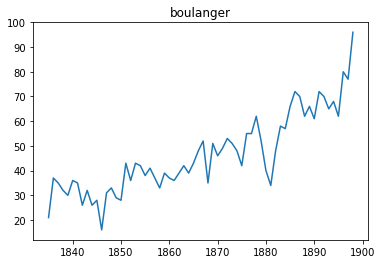

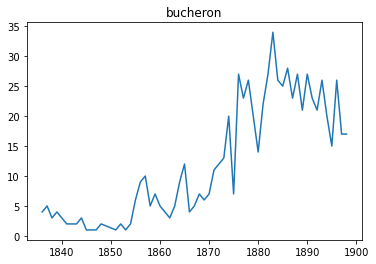

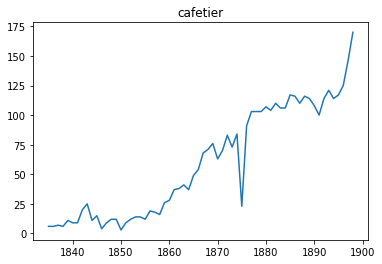

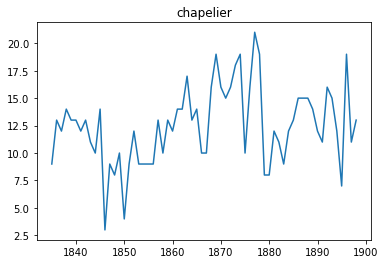

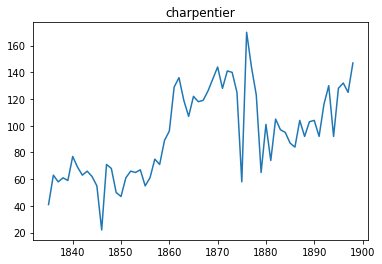

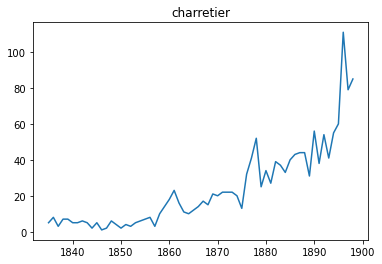

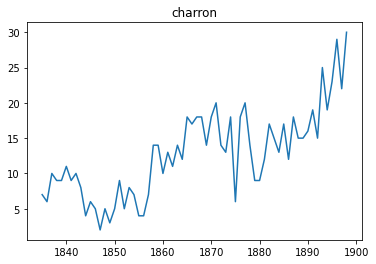

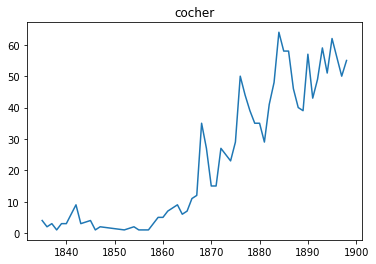

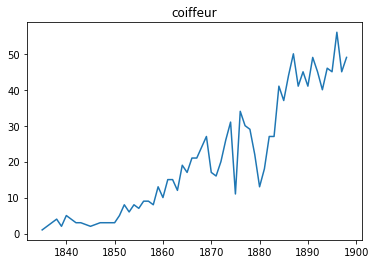

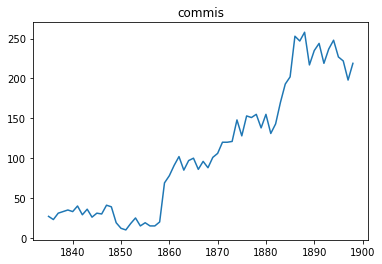

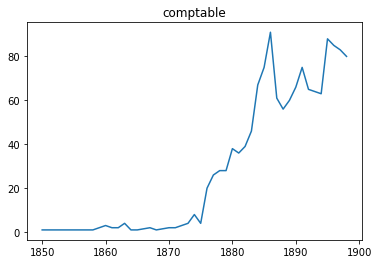

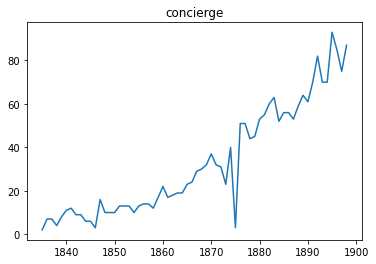

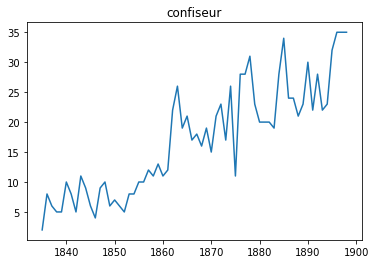

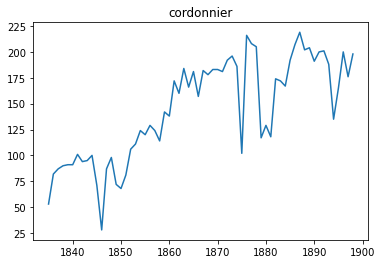

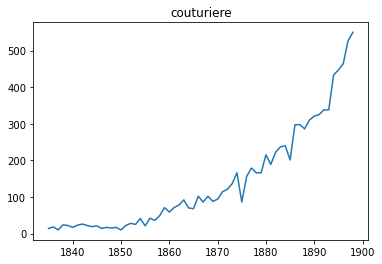

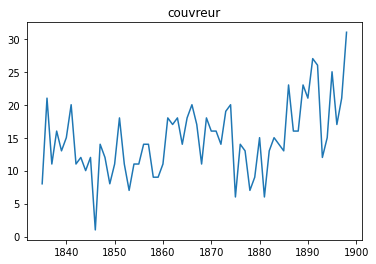

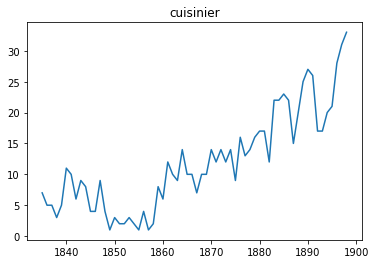

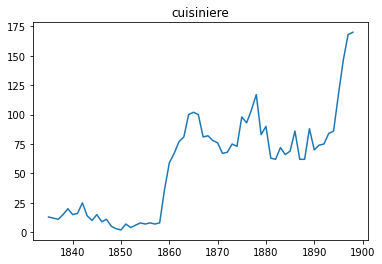

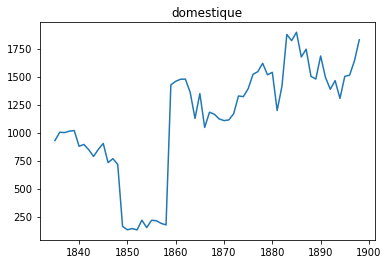

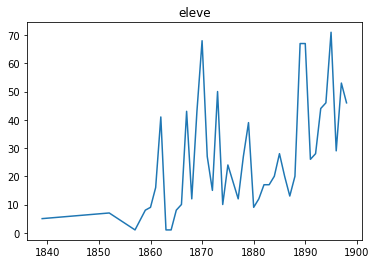

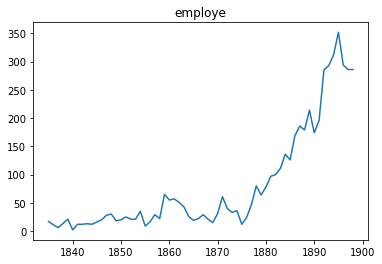

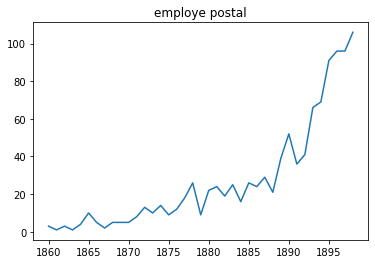

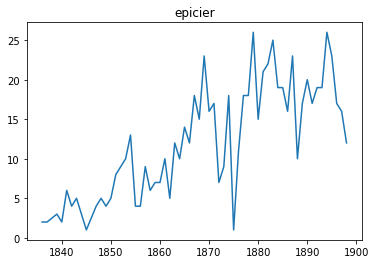

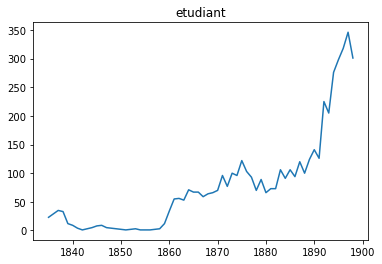

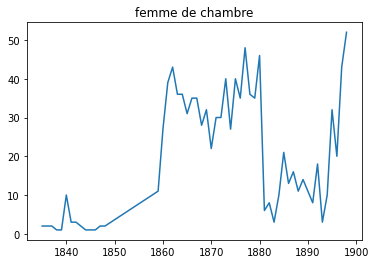

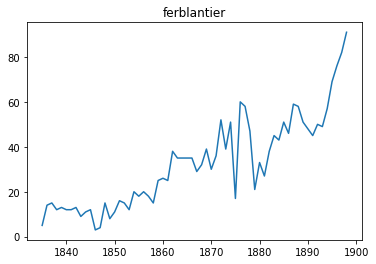

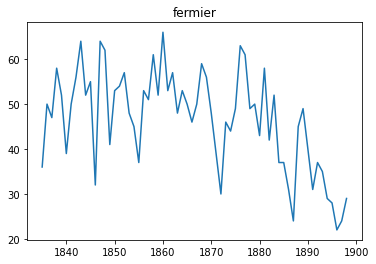

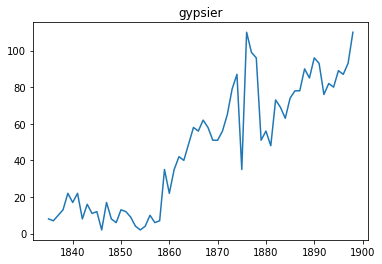

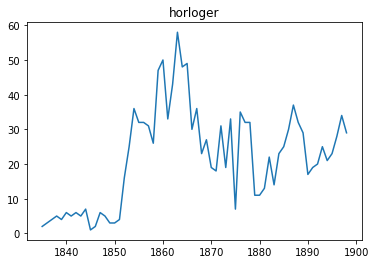

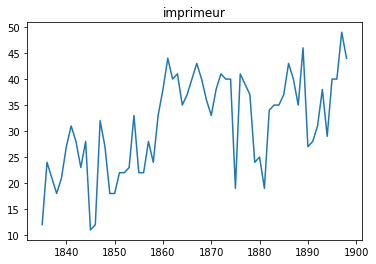

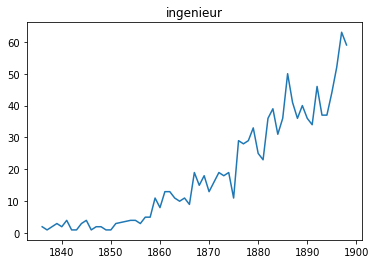

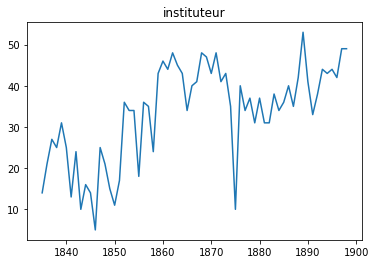

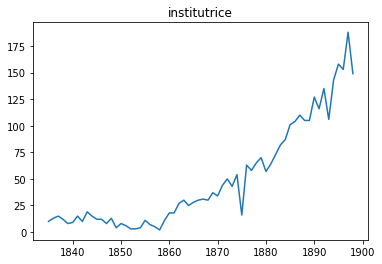

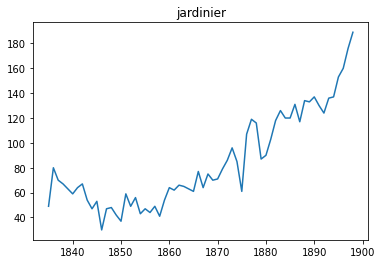

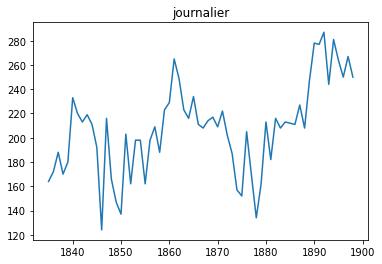

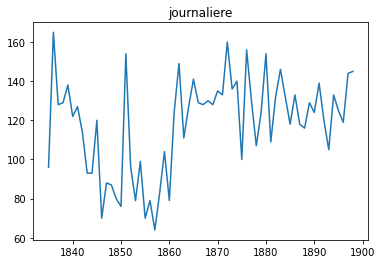

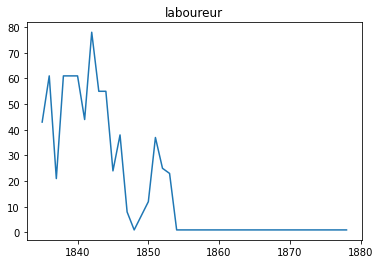

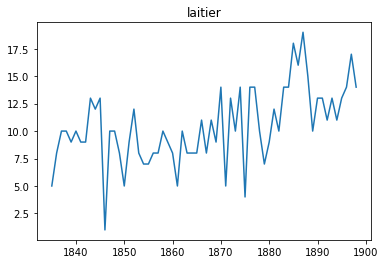

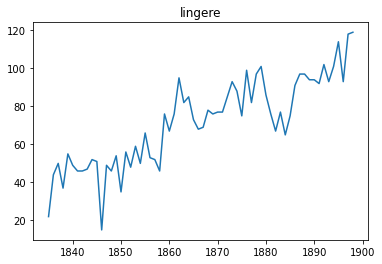

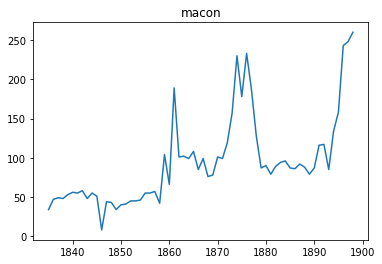

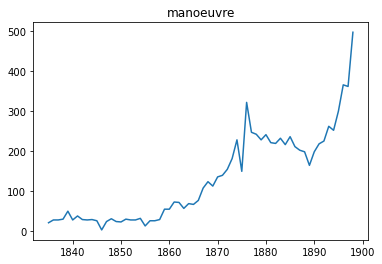

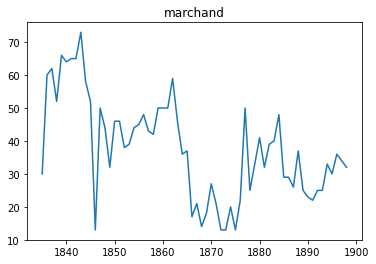

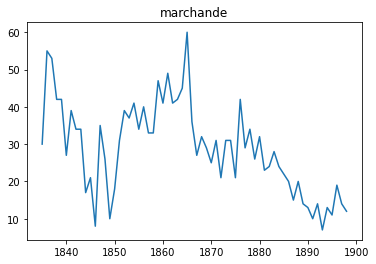

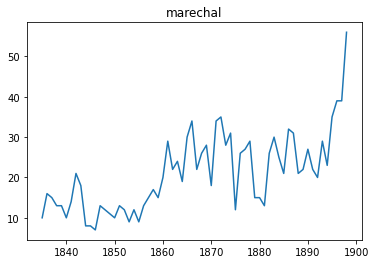

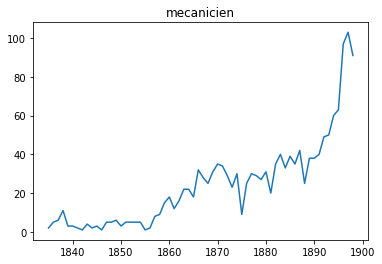

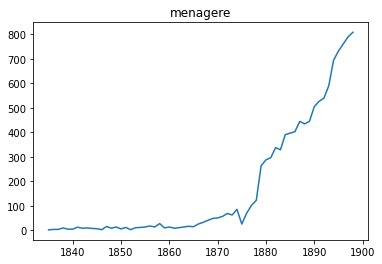

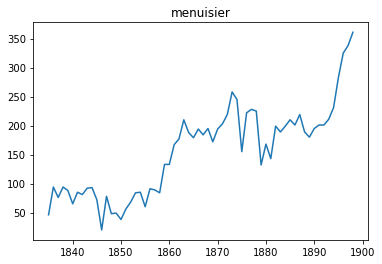

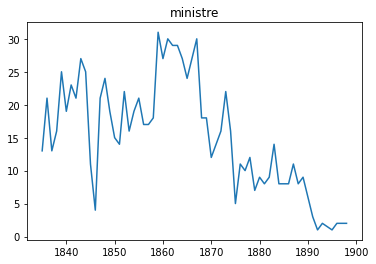

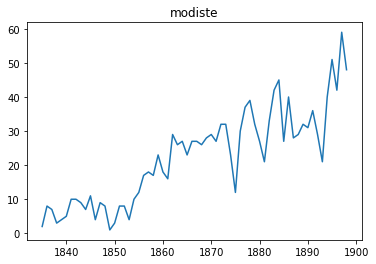

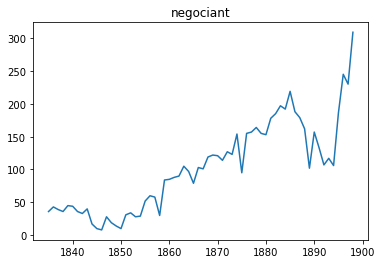

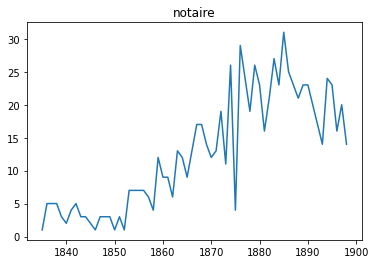

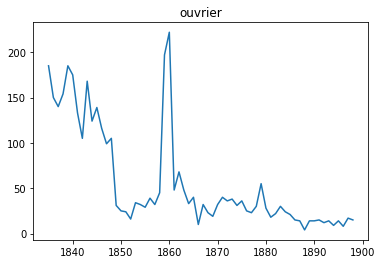

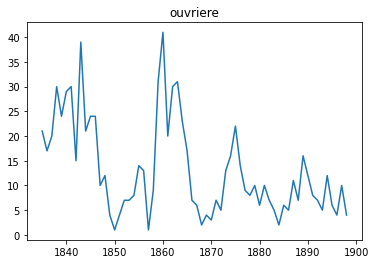

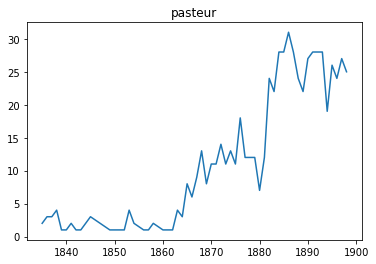

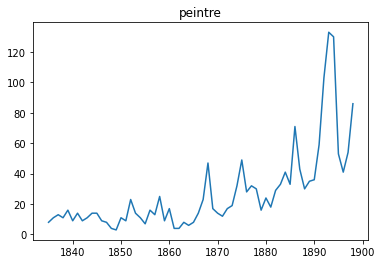

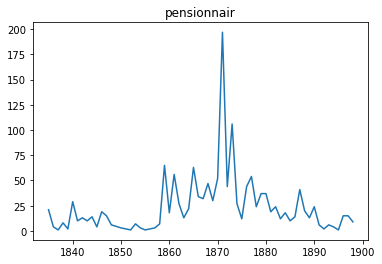

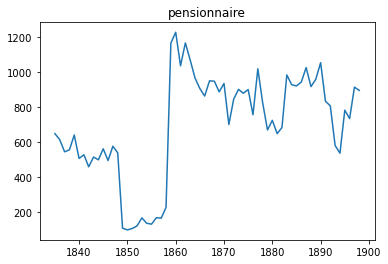

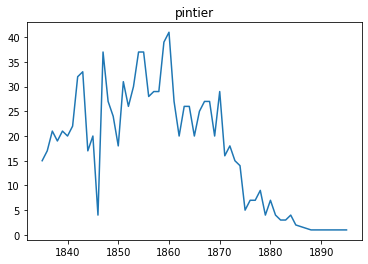

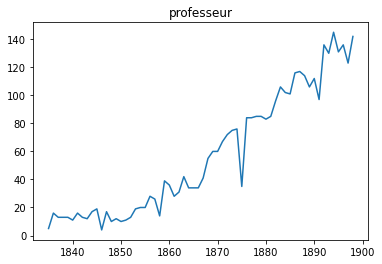

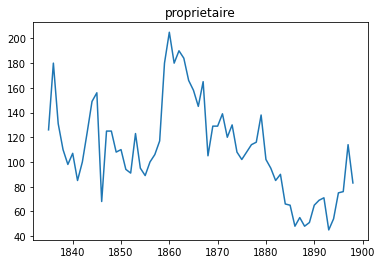

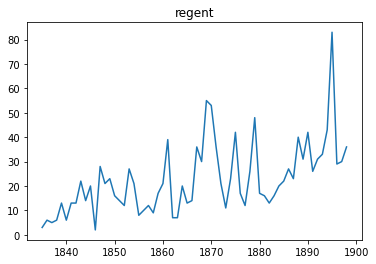

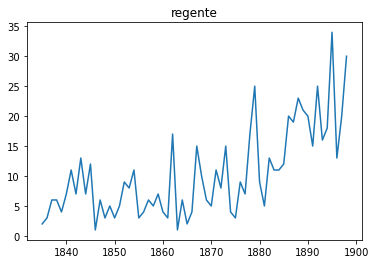

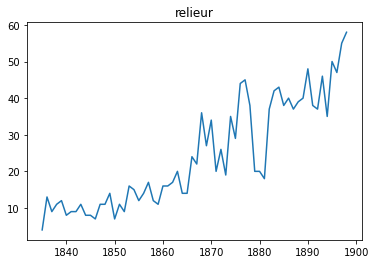

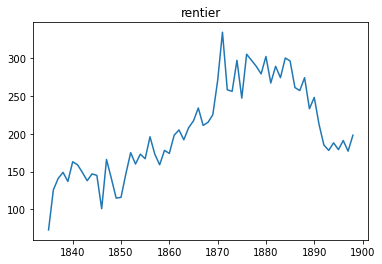

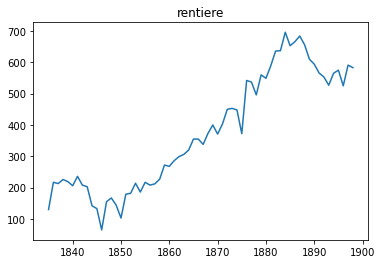

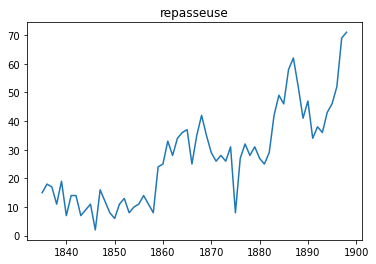

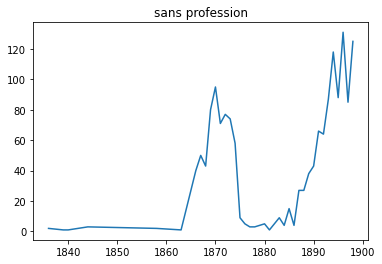

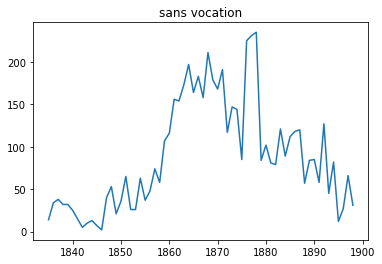

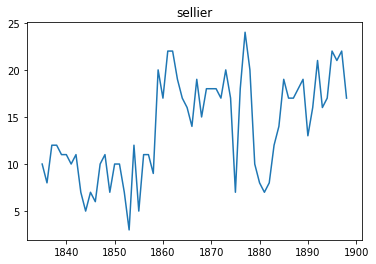

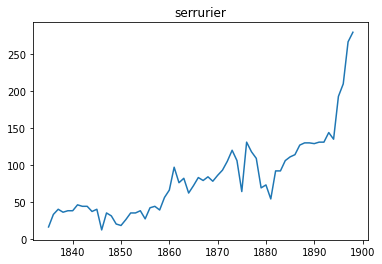

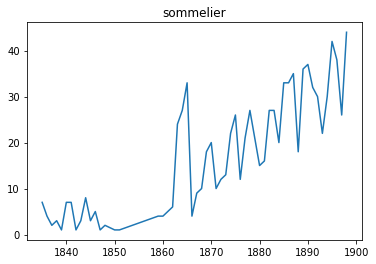

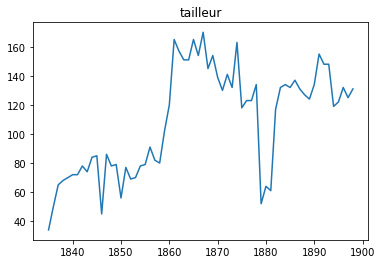

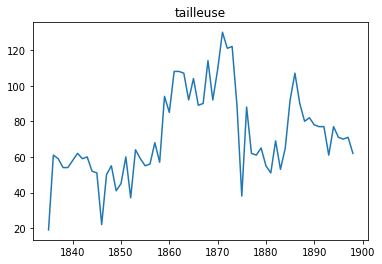

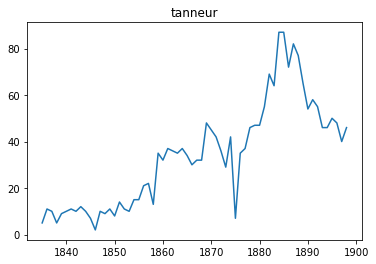

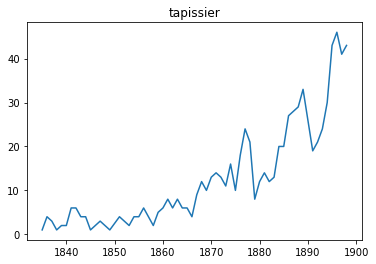

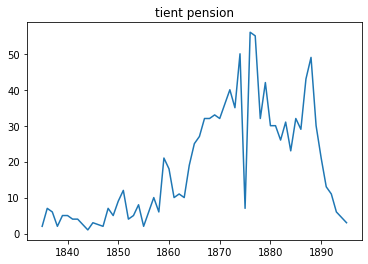

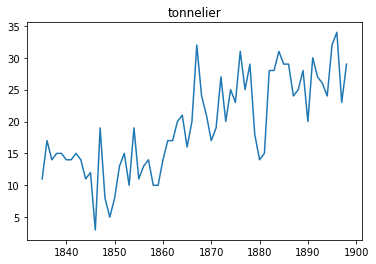

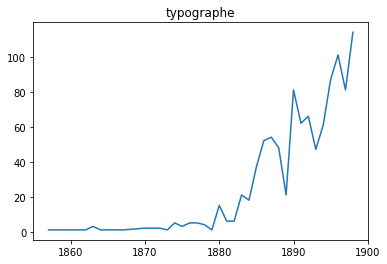

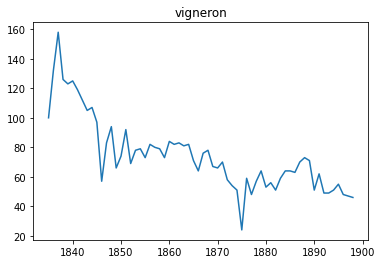

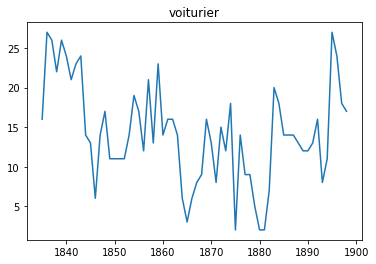

In [26]:
top_job = list(occ_per_job[occ_per_job > 640].index)

for job in top_job:
    plot_evolution(df_selected_jobs_occ, job, "profession", "occ_by_year/") 

In [27]:
df_occ_per = df_selected_jobs_occ.set_index("annee").join(df_selected_jobs_occ.groupby("annee")["occ"].sum().to_frame(), lsuffix = "_job", rsuffix ="_pop")
df_occ_per["occ_per"] = df_occ_per["occ_job"] / df_occ_per["occ_pop"]
df_occ_per

profession  occ_job  occ_pop   occ_per
annee                                                 
1835           agriculteur       22     3706  0.005936
1835              apprenti       49     3706  0.013222
1835             apprentie       19     3706  0.005127
1835   apprentie tailleuse        1     3706  0.000270
1835              armurier        3     3706  0.000809
...                    ...      ...      ...       ...
1898                 veuve        2    13488  0.000148
1898              vigneron       46    13488  0.003410
1898               vitrier       14    13488  0.001038
1898             voiturier       17    13488  0.001260
1898            volontaire       16    13488  0.001186

[10924 rows x 4 columns]

In [28]:
def plot_evolution_percent(df, job_name, col_name, plot_dir):
    data = df[df[col_name]==job_name]
    plt.plot(data.index, data["occ_per"] * 100)
    plt.title("% of "+job_name)
    plt.savefig(PLOT_DIR+ plot_dir +job_name + ".png")
    plt.show()

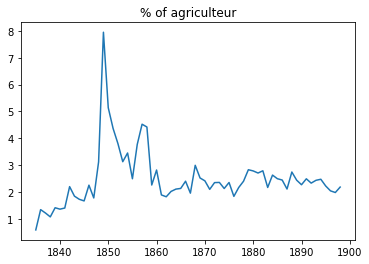

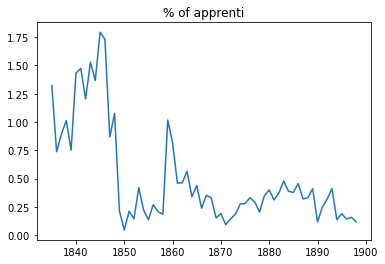

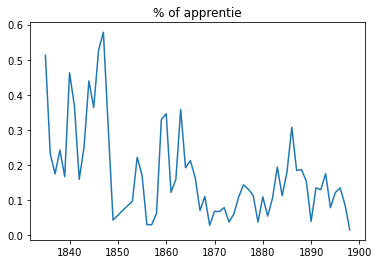

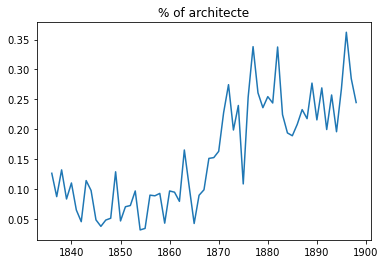

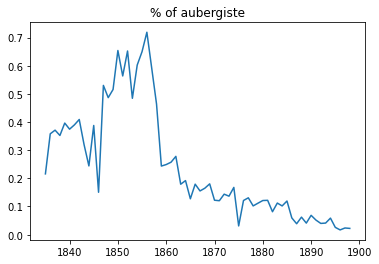

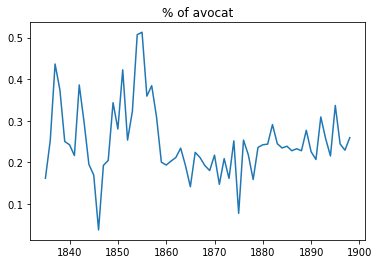

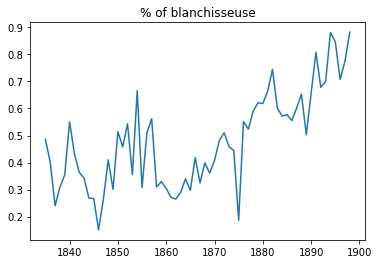

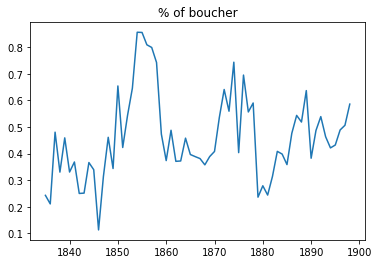

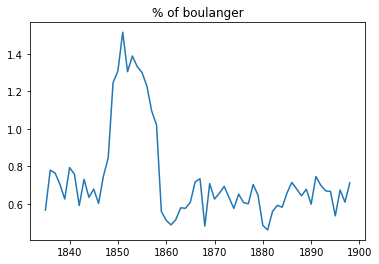

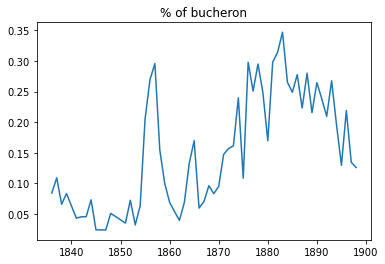

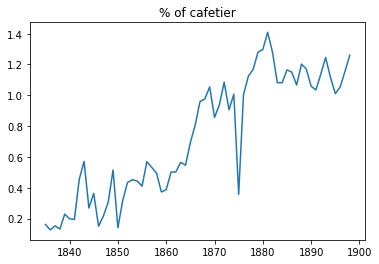

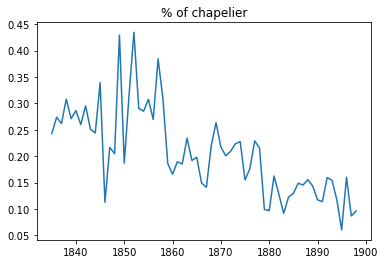

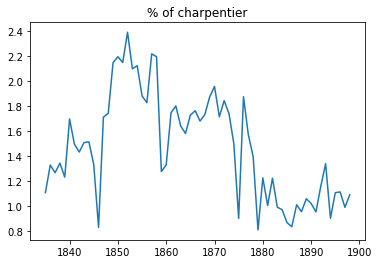

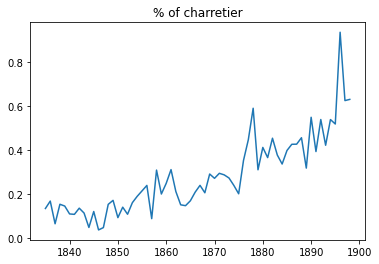

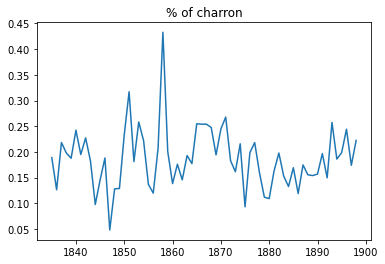

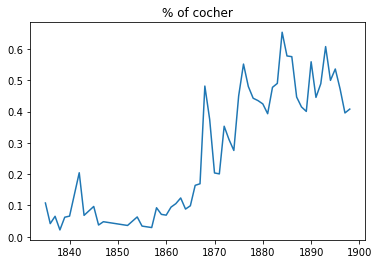

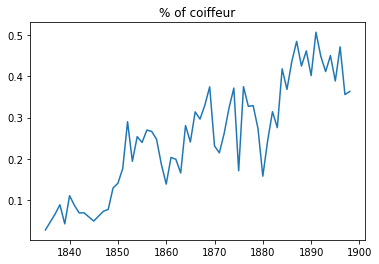

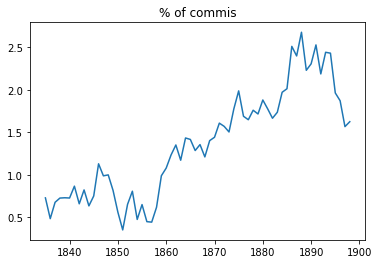

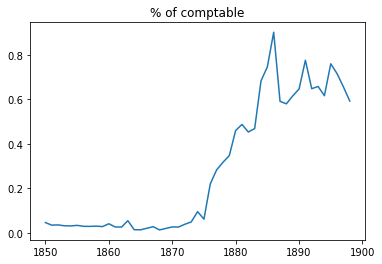

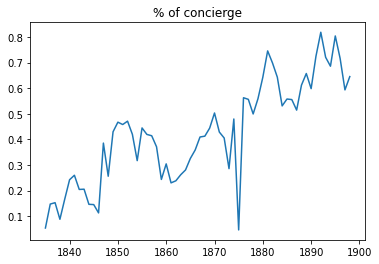

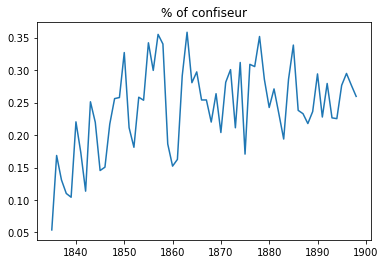

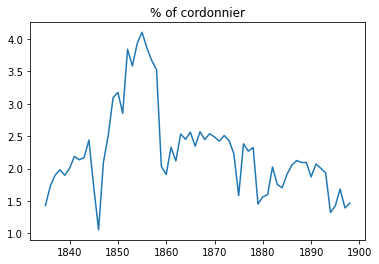

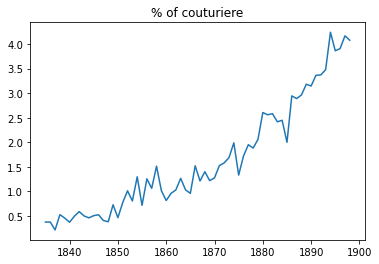

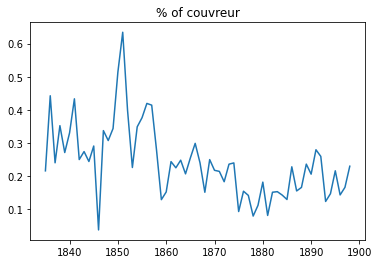

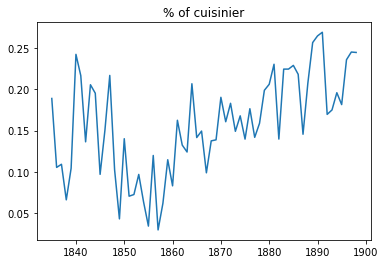

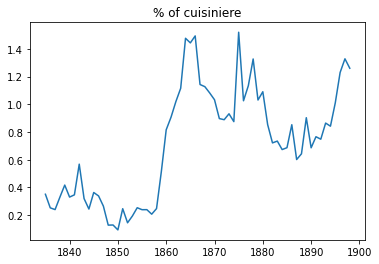

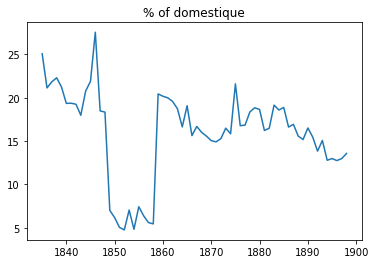

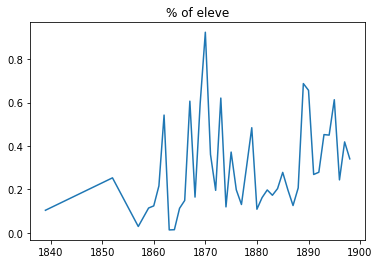

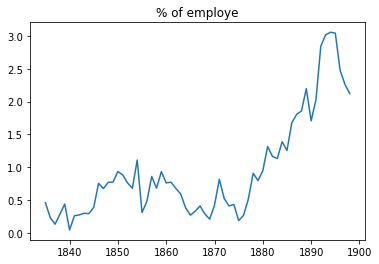

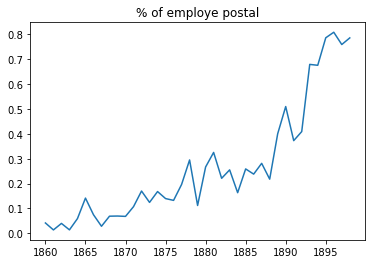

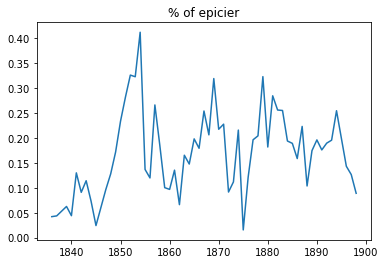

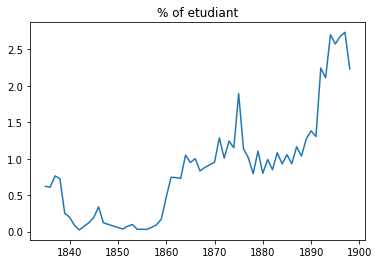

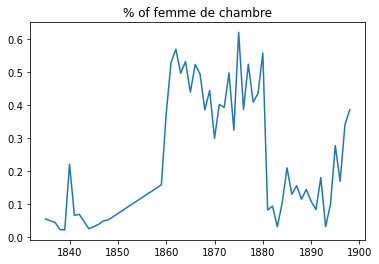

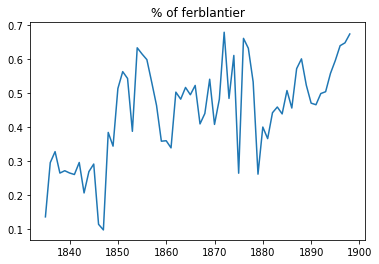

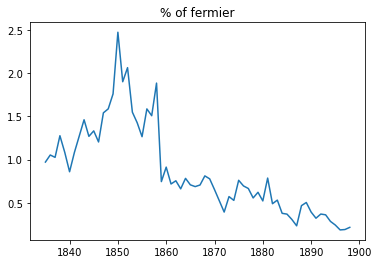

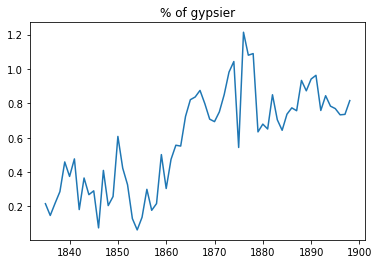

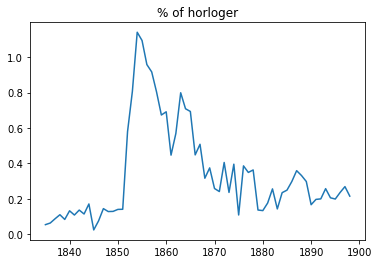

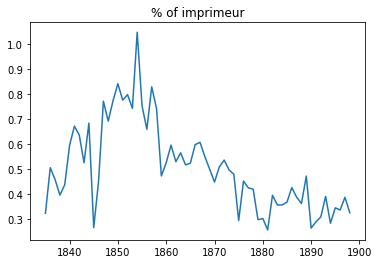

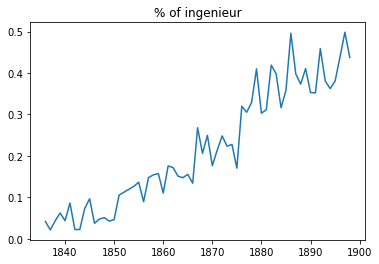

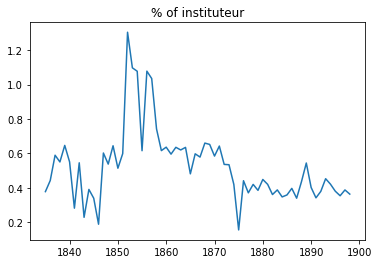

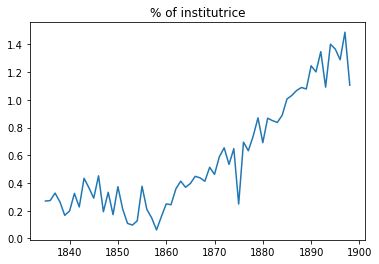

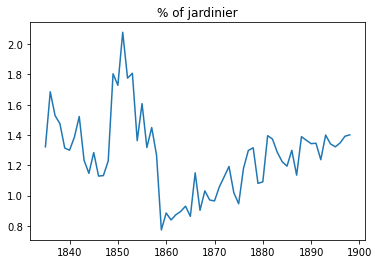

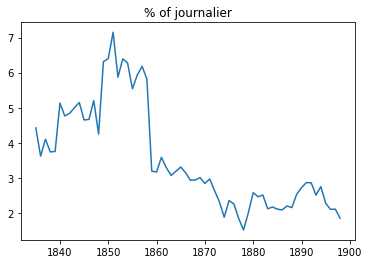

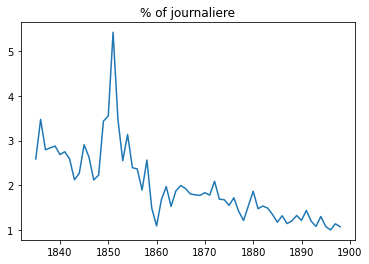

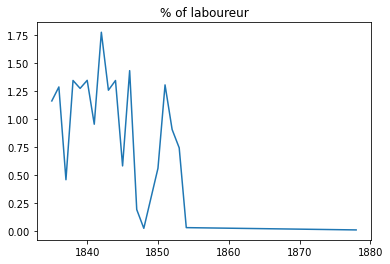

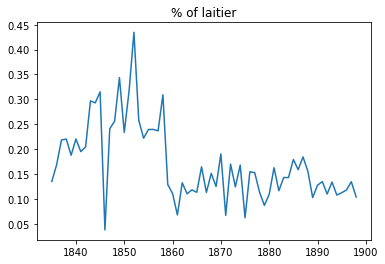

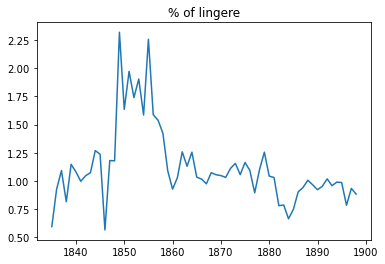

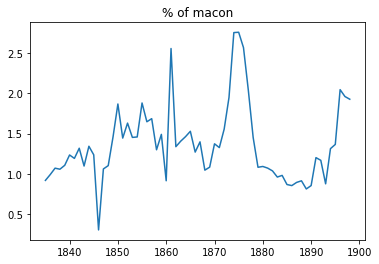

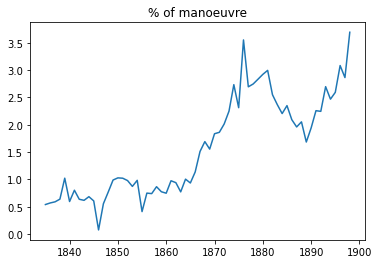

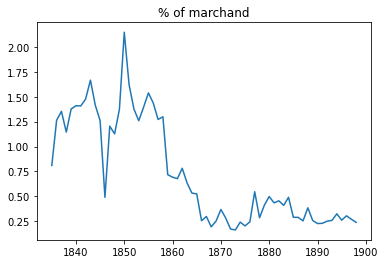

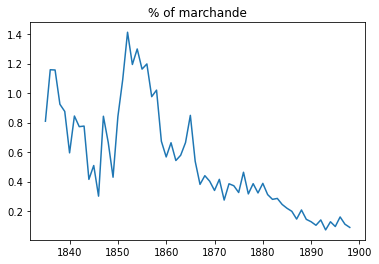

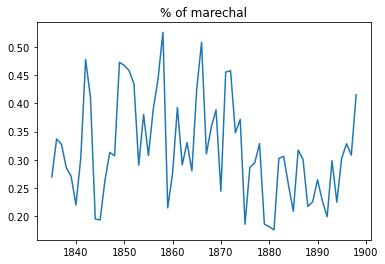

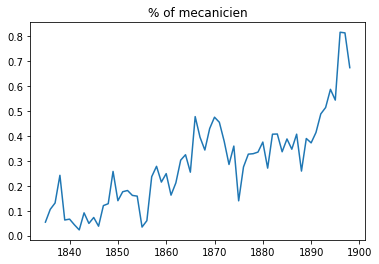

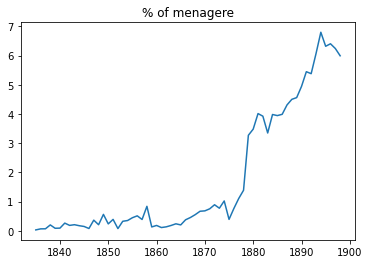

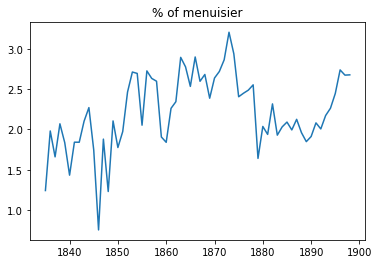

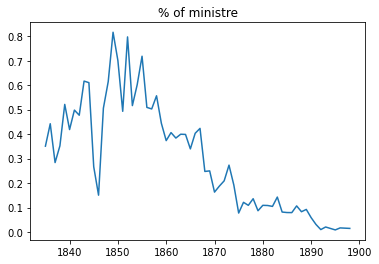

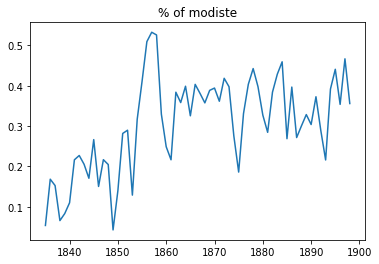

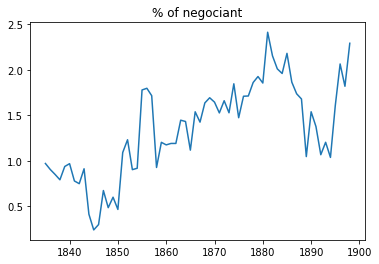

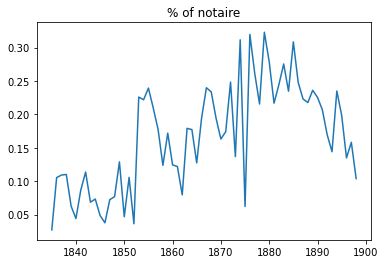

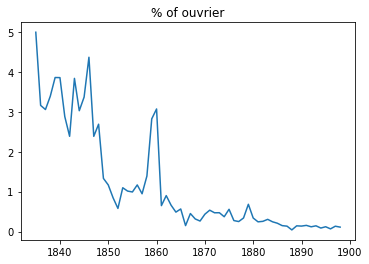

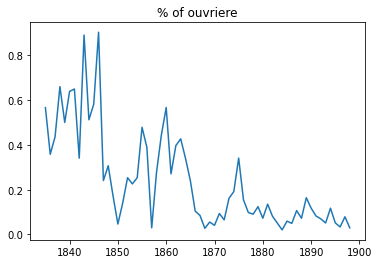

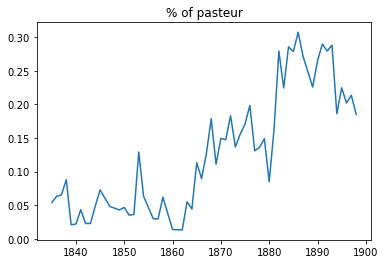

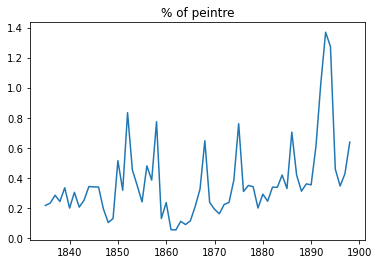

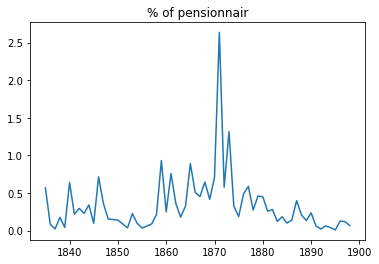

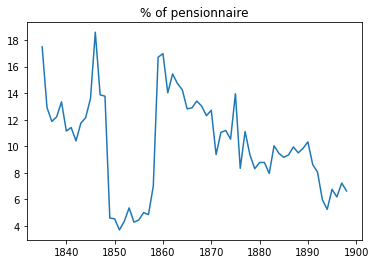

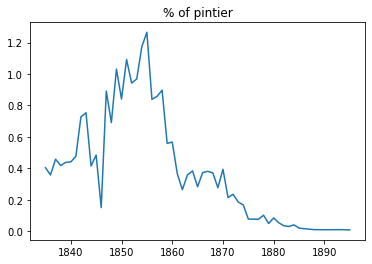

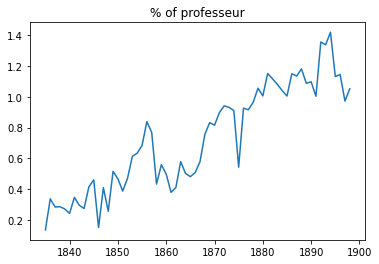

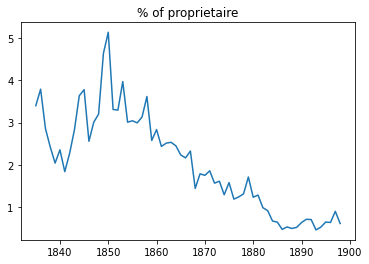

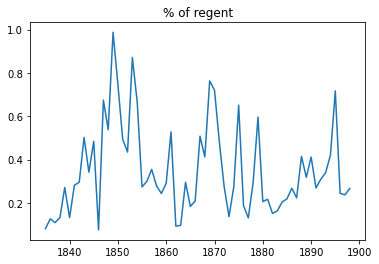

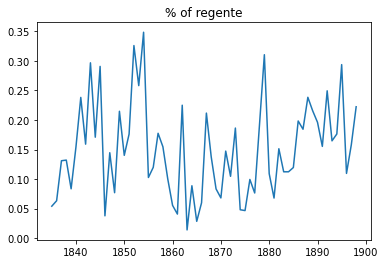

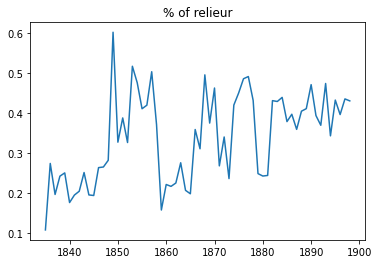

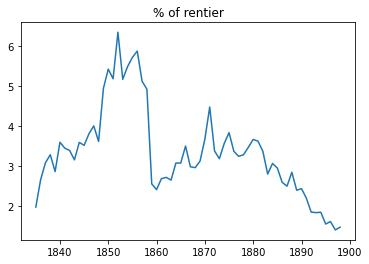

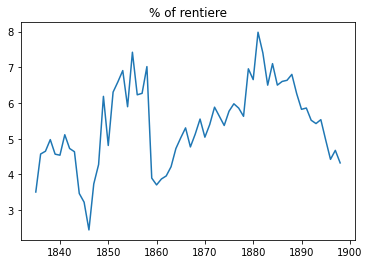

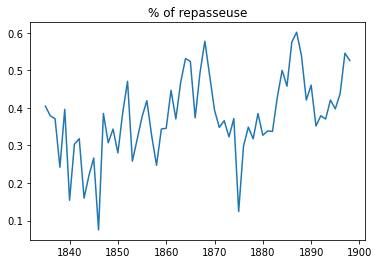

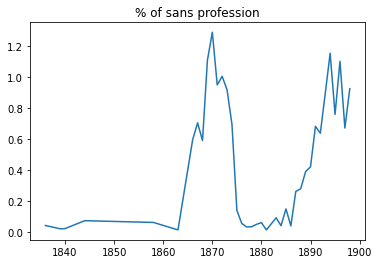

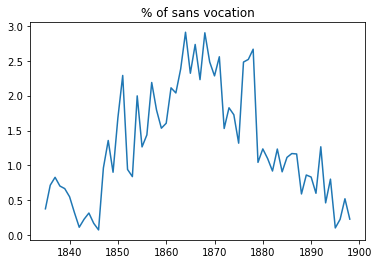

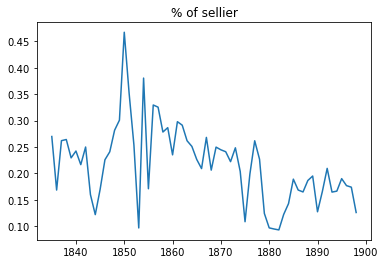

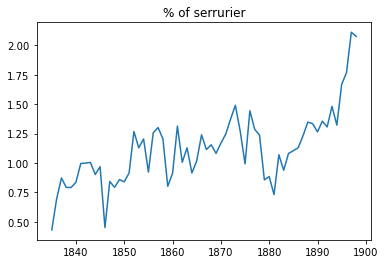

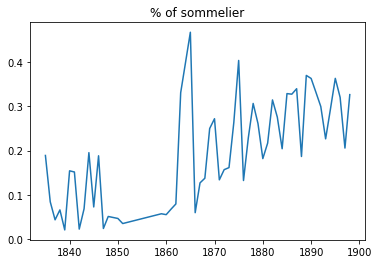

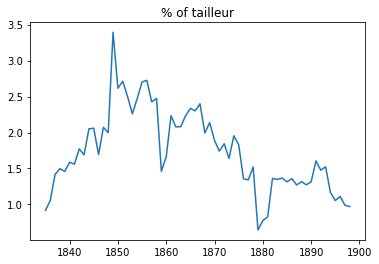

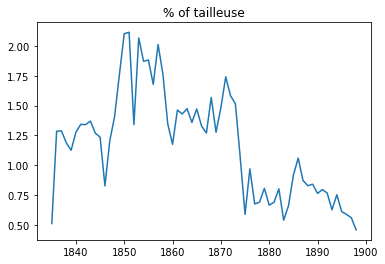

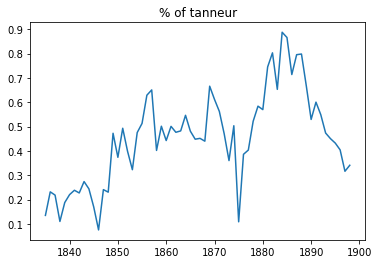

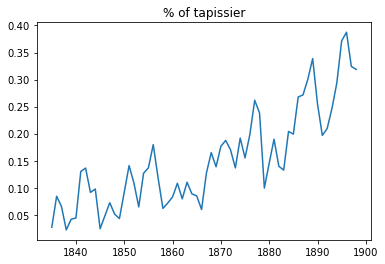

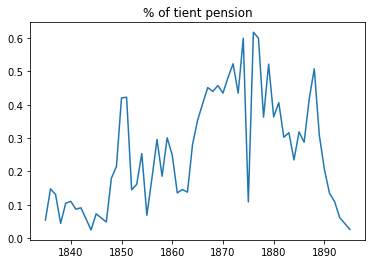

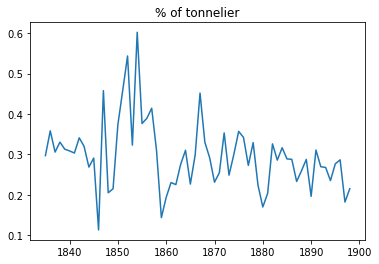

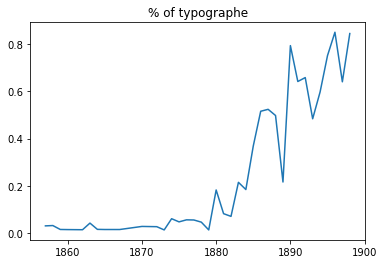

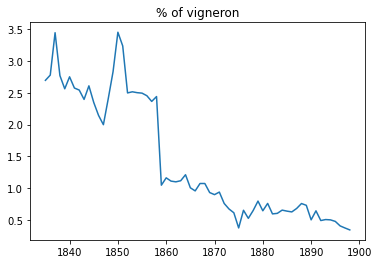

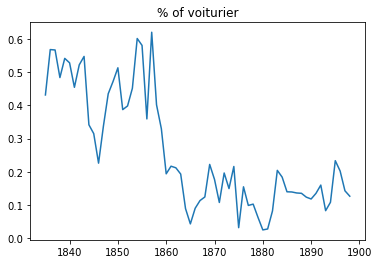

In [29]:
for job in top_job:
    plot_evolution_percent(df_occ_per, job, "profession", "per_by_year/") 

### Métiers les plus fréquents par année

In [30]:
def plot_top_job(df,col_name, num_top, plot_dir):
    years = sorted(df["annee"].unique())
    for year in years:
        data = df[df["annee"] == year].sort_values("occ")[::-1][:num_top]
        plt.figure(figsize=(15, 5))
        plt.bar(data[col_name], data["occ"])
        plt.title(f'Top {num_top} for year {year}')
        plt.savefig(PLOT_DIR+ plot_dir + str(year) + ".png")
        plt.show()  

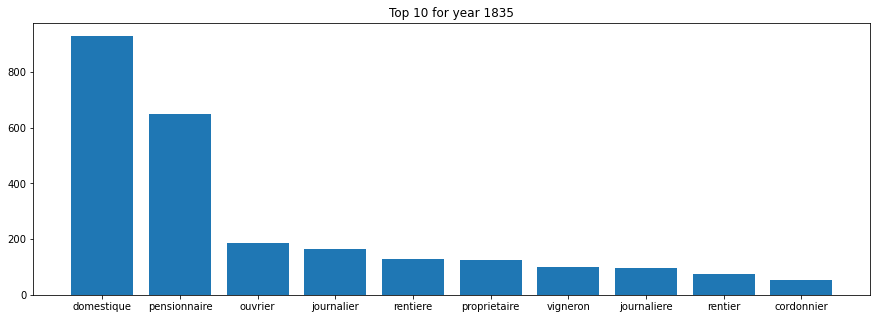

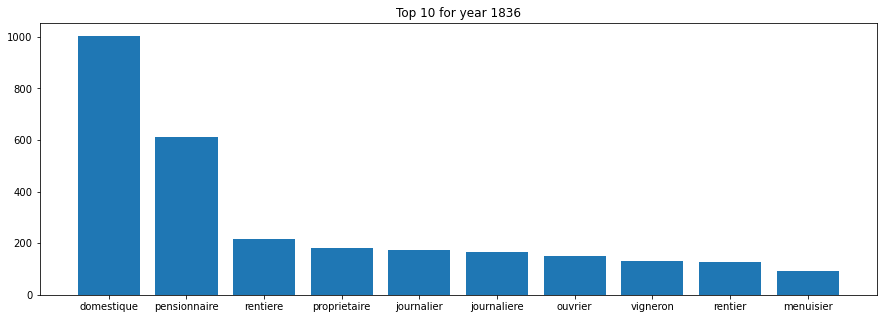

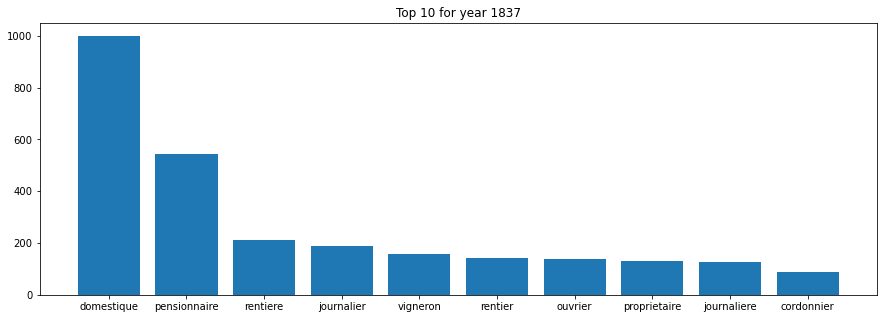

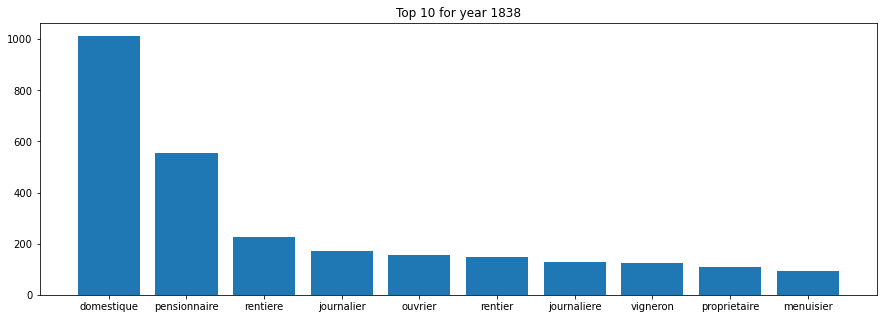

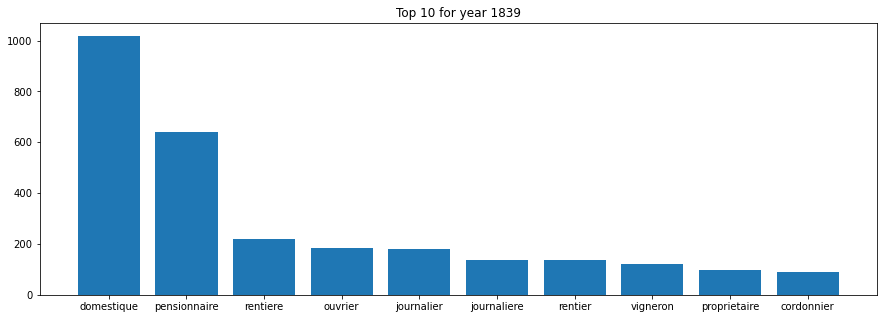

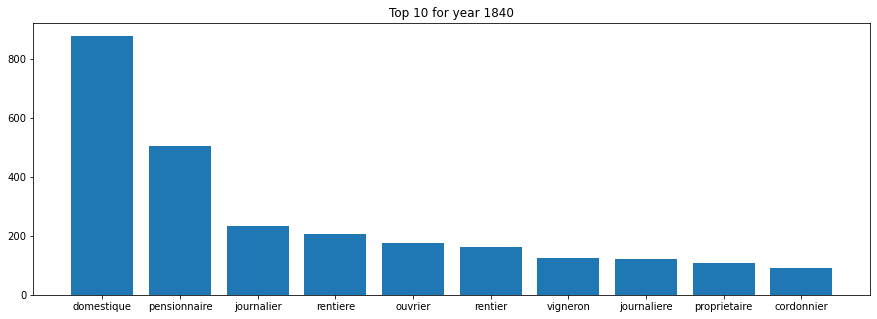

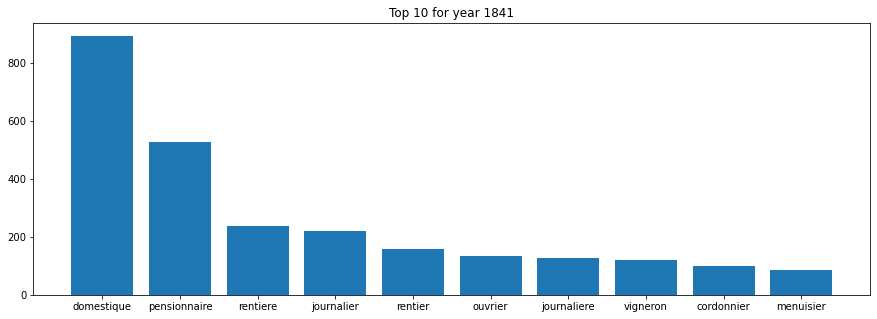

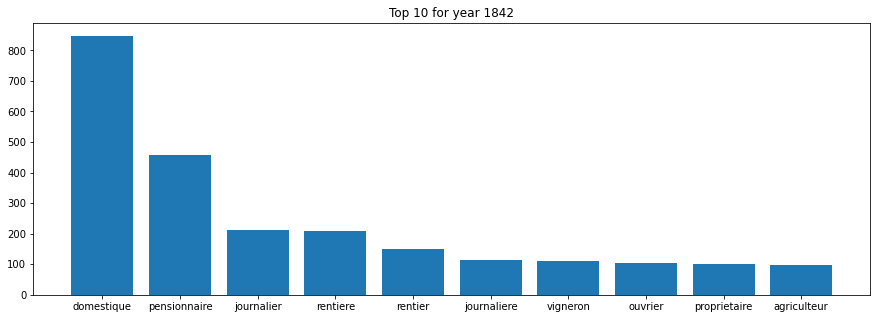

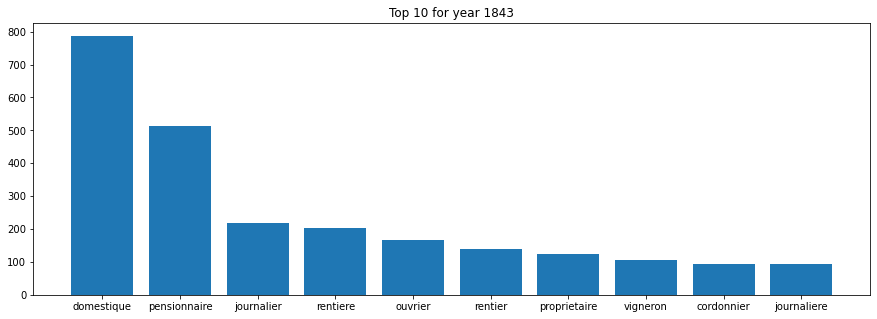

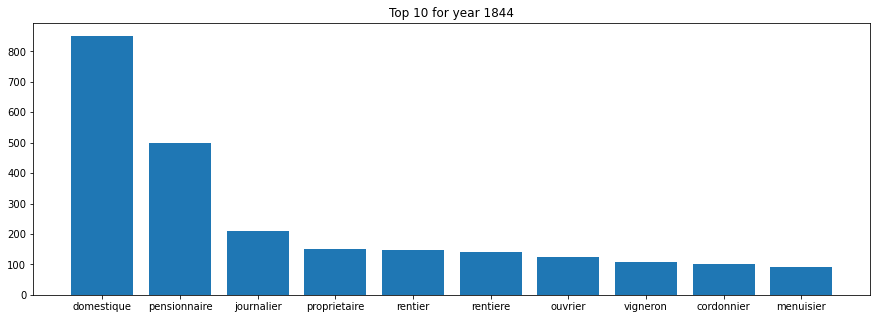

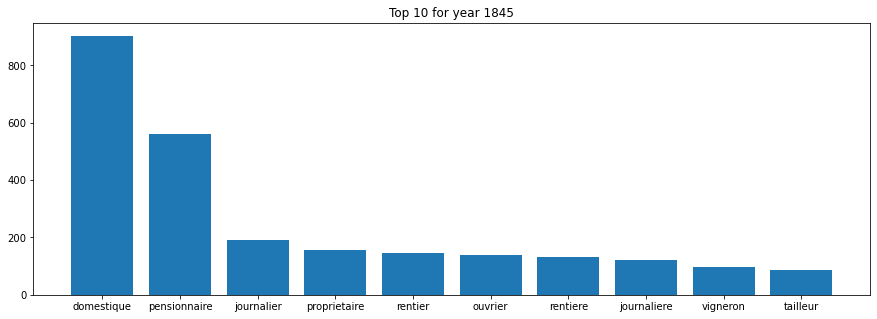

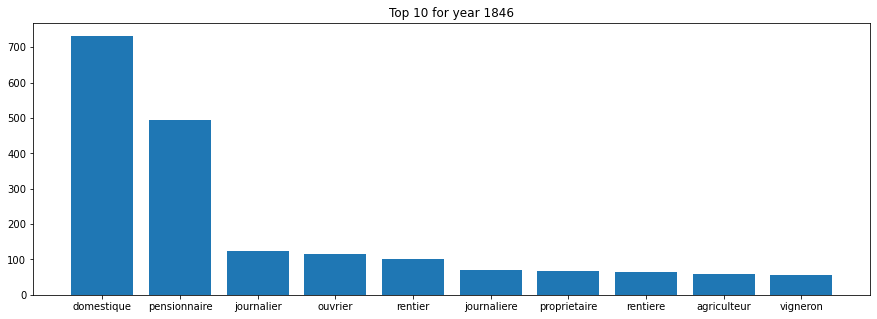

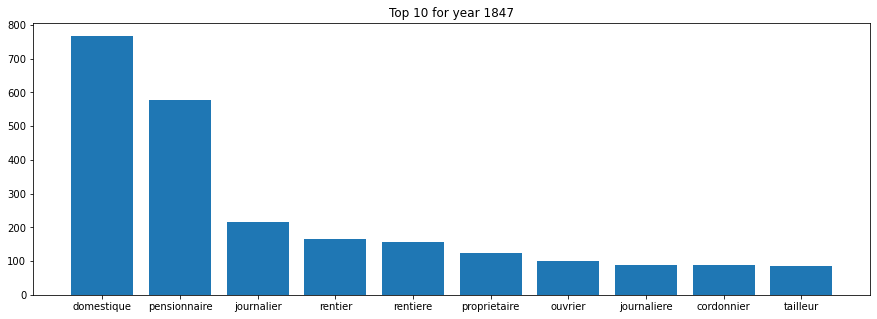

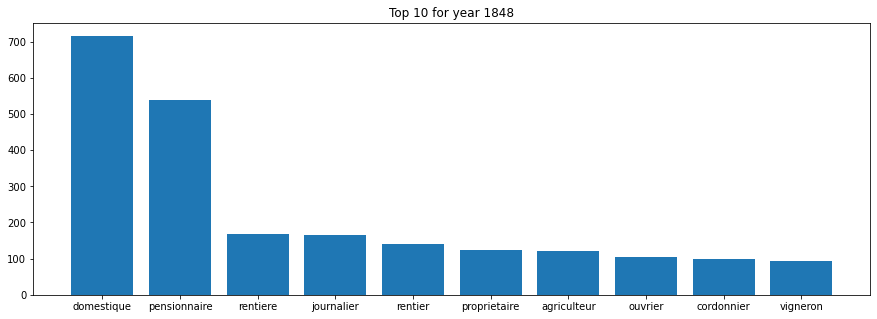

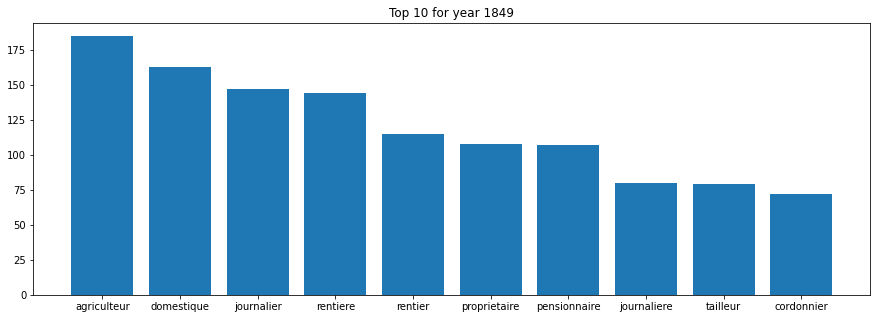

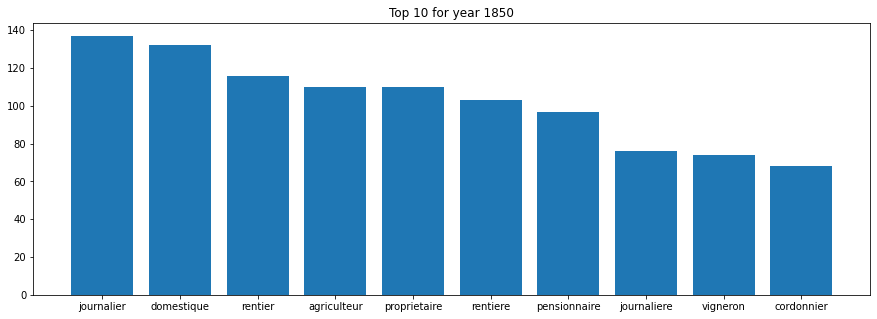

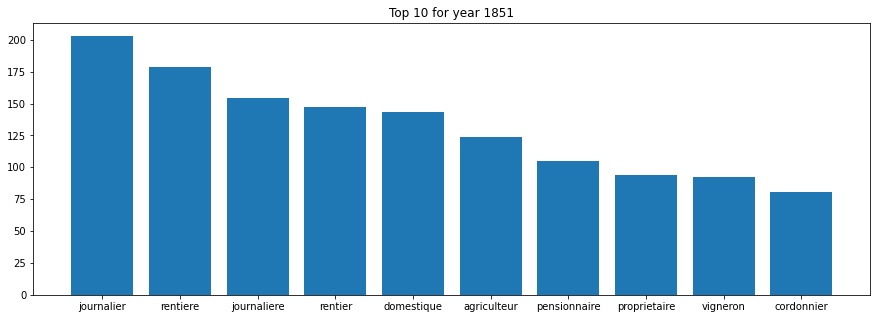

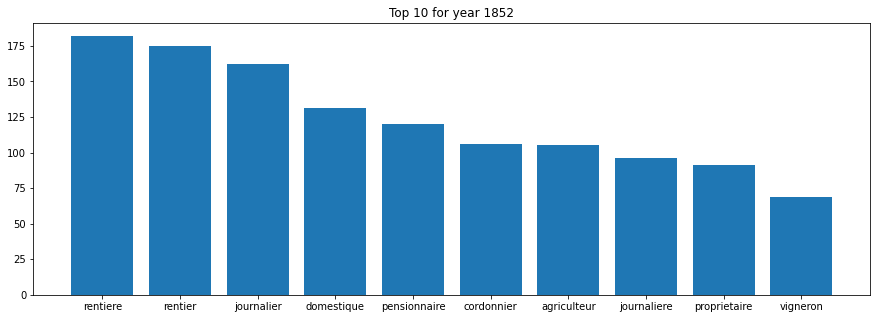

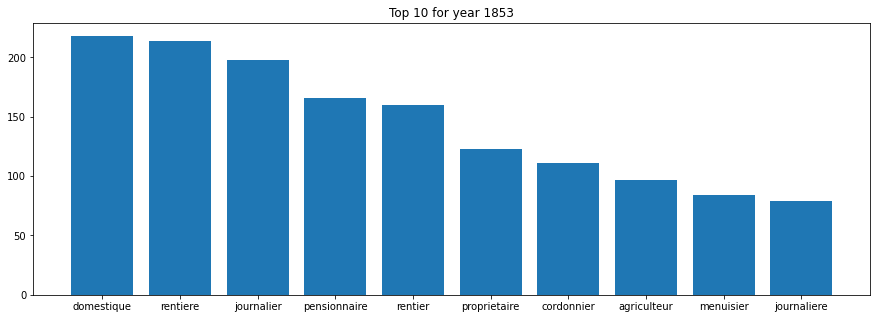

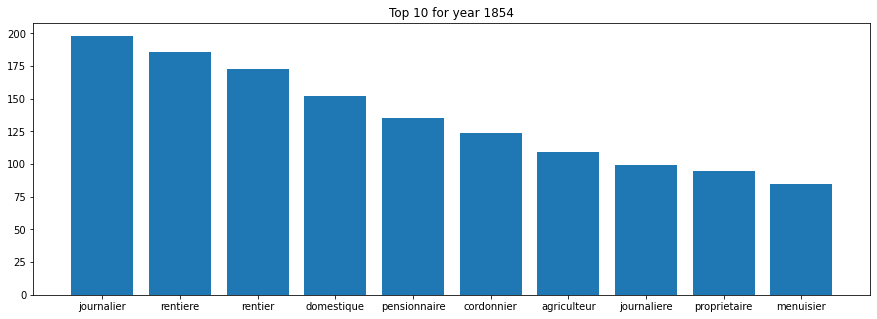

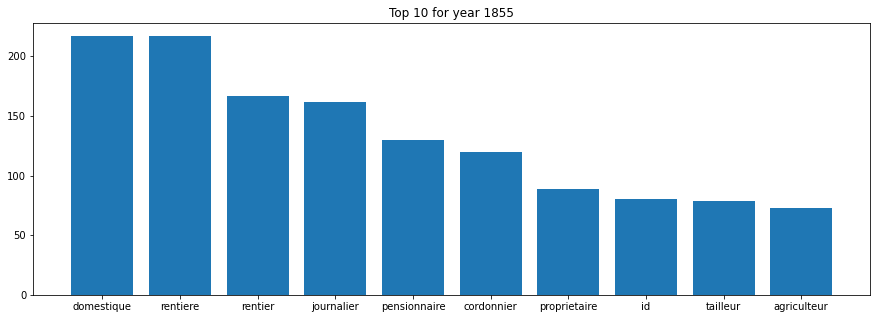

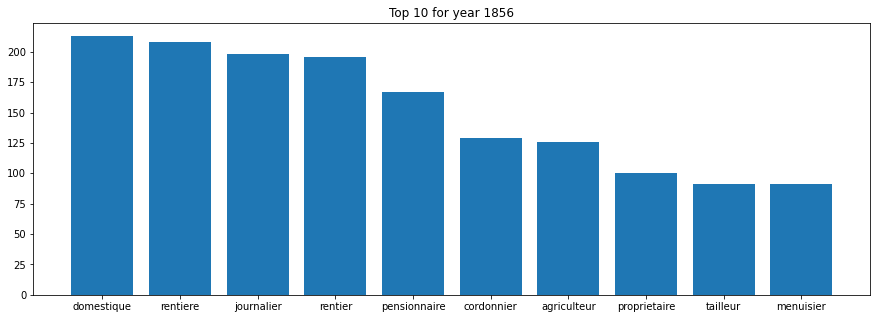

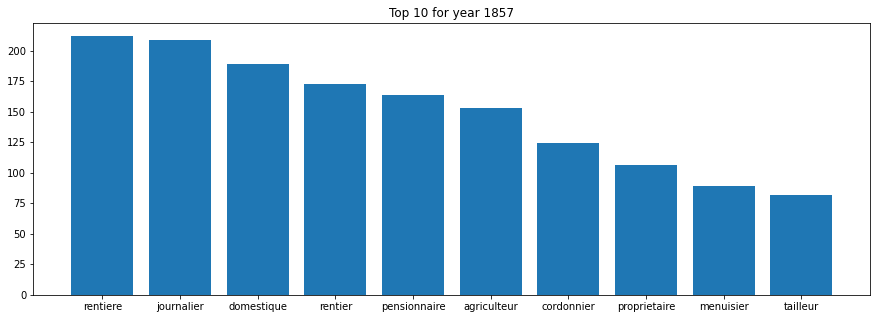

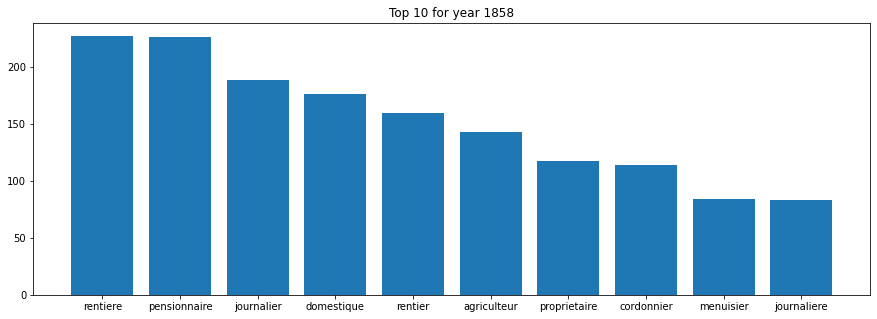

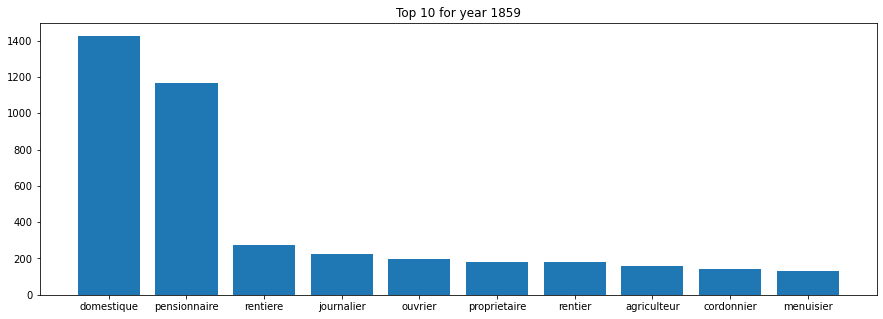

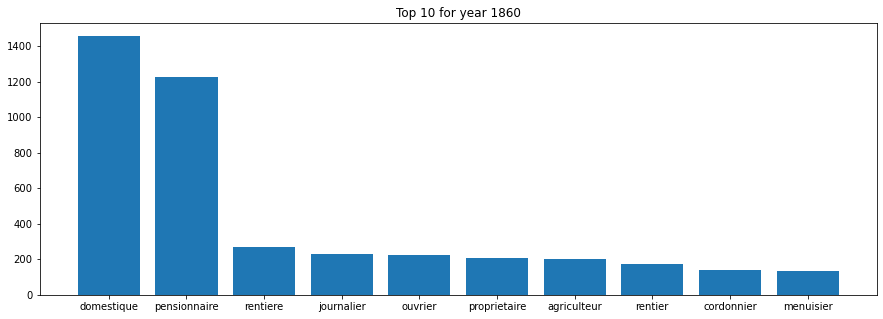

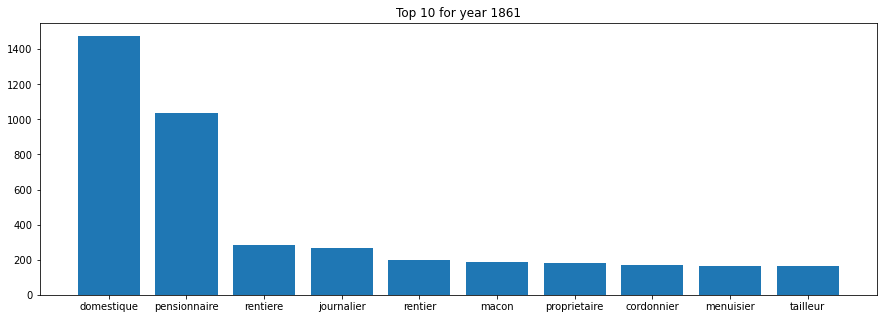

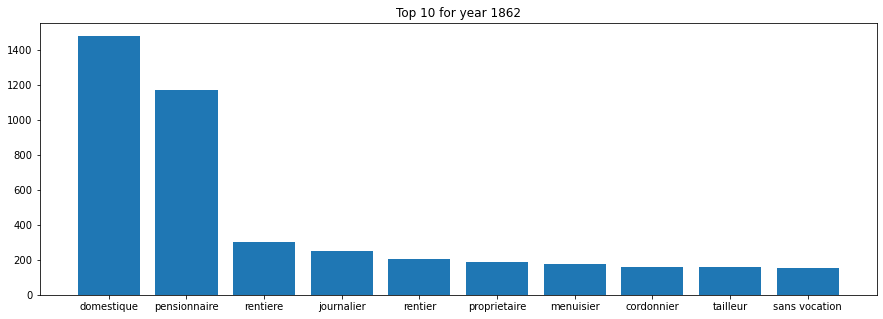

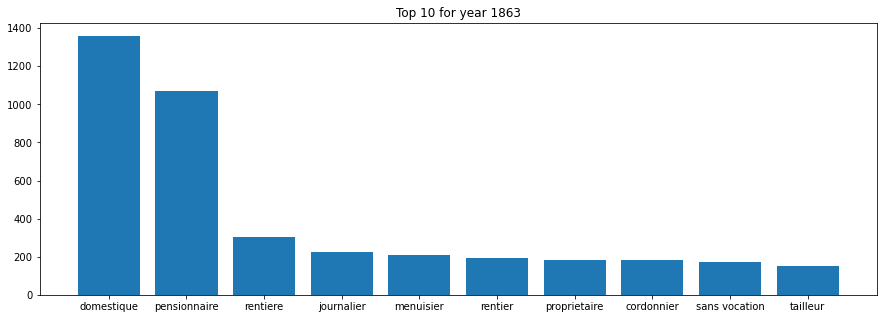

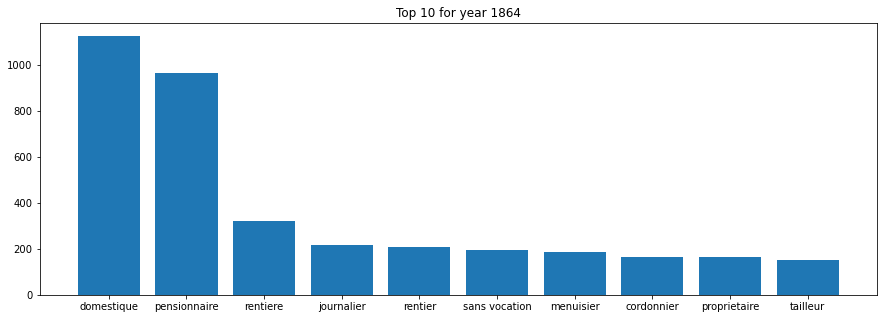

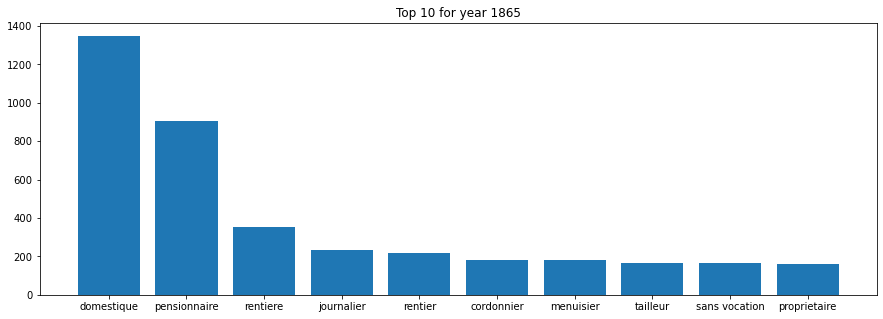

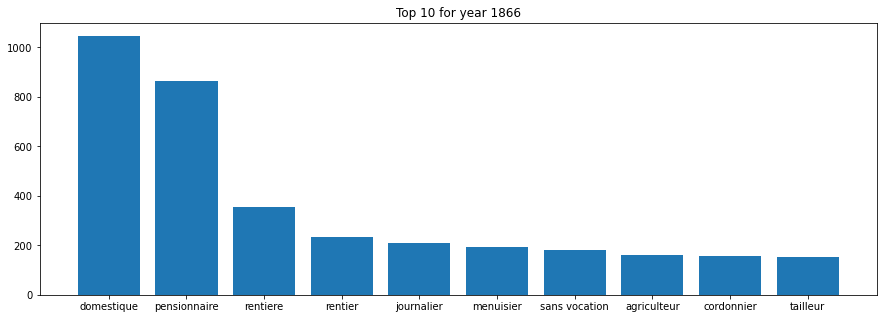

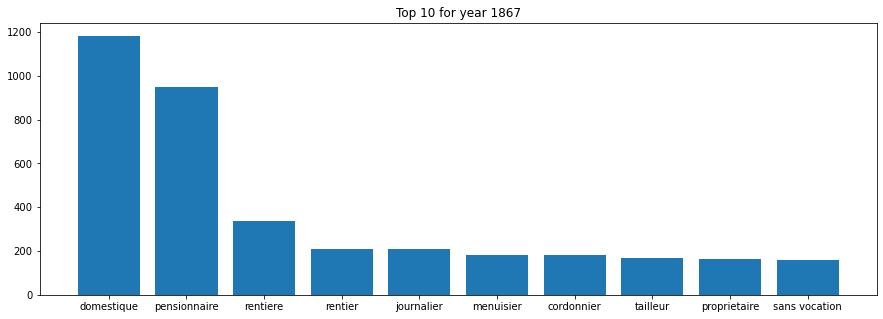

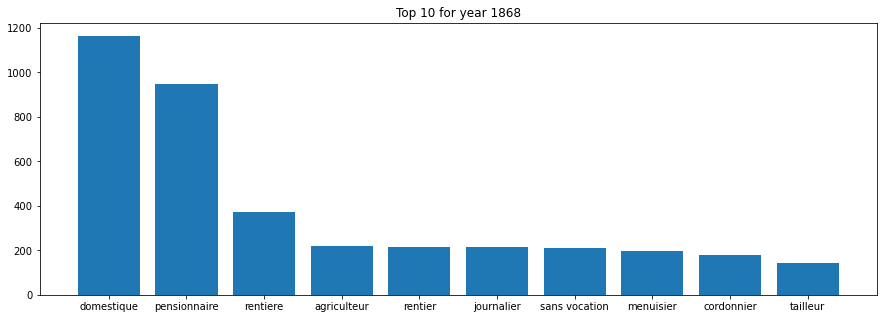

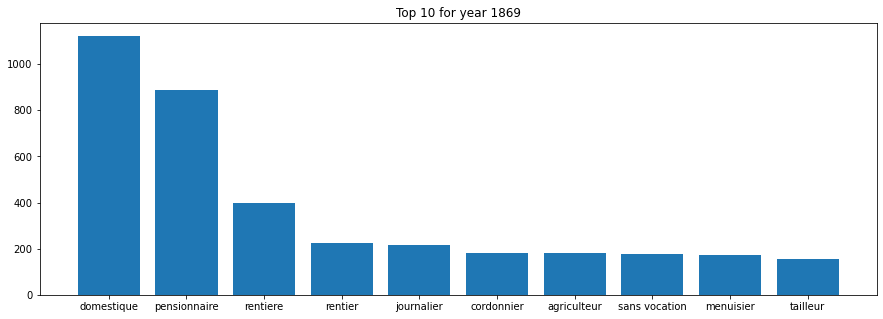

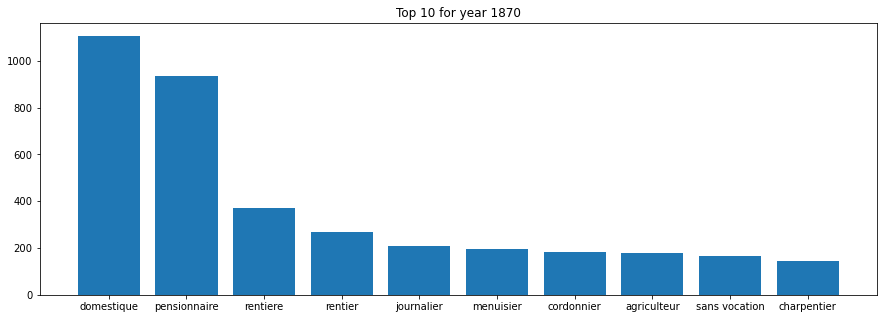

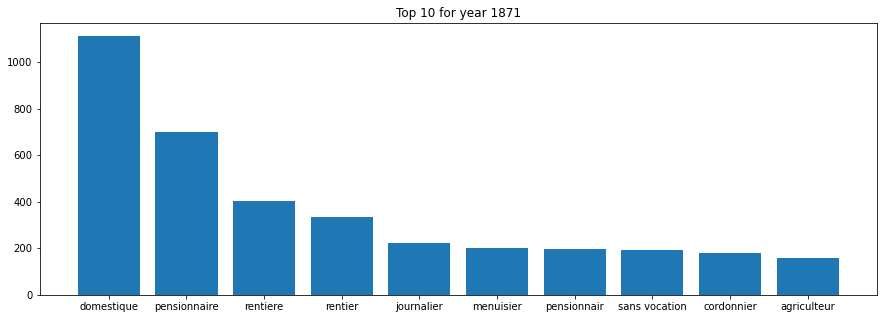

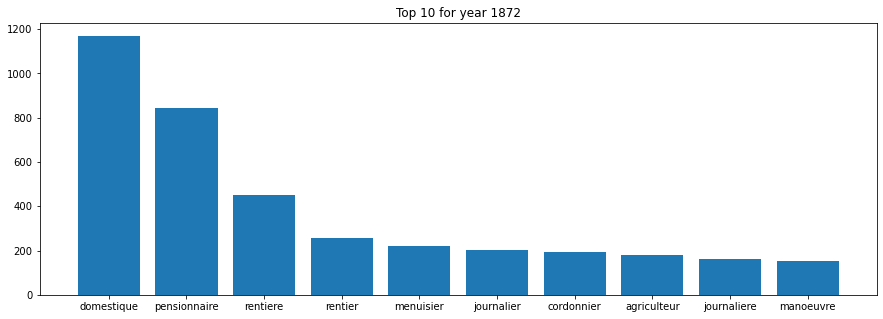

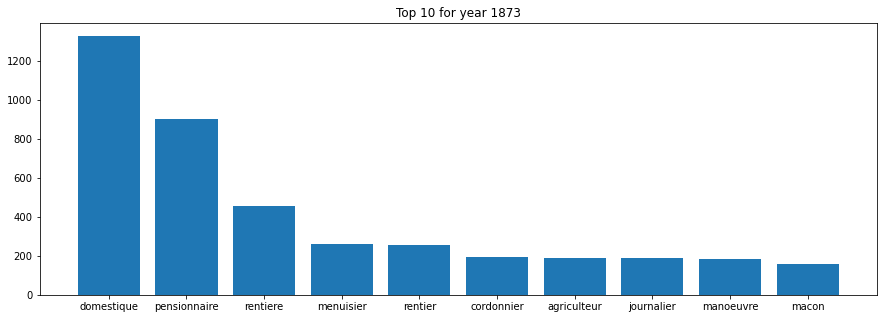

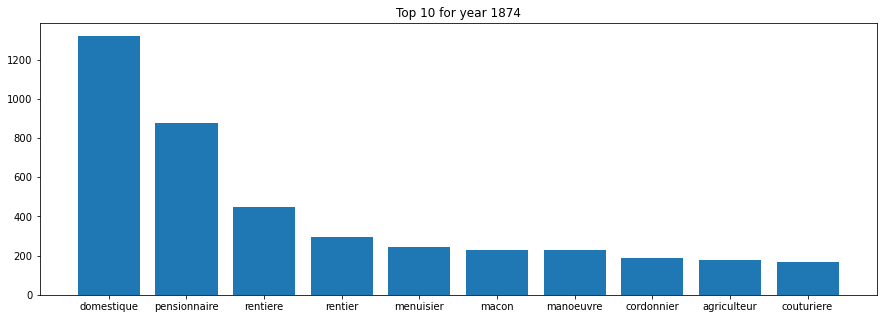

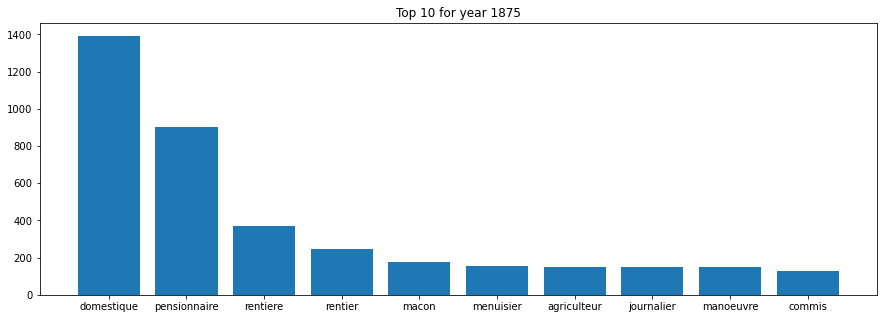

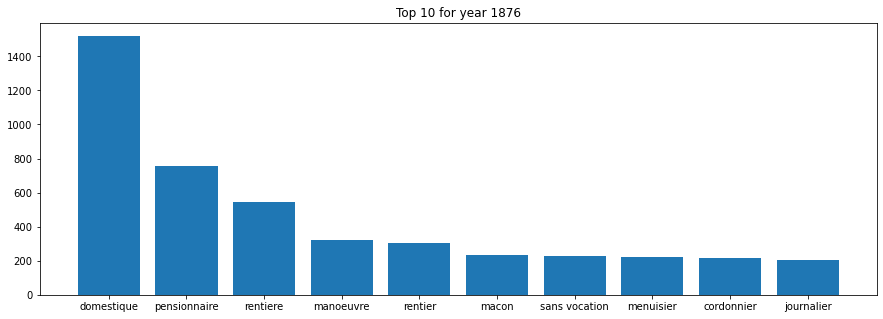

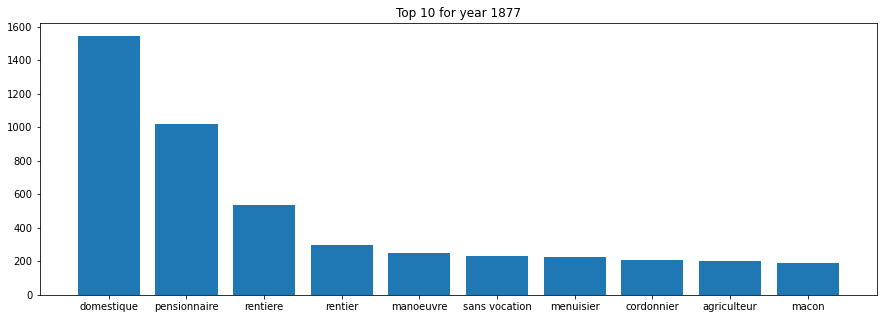

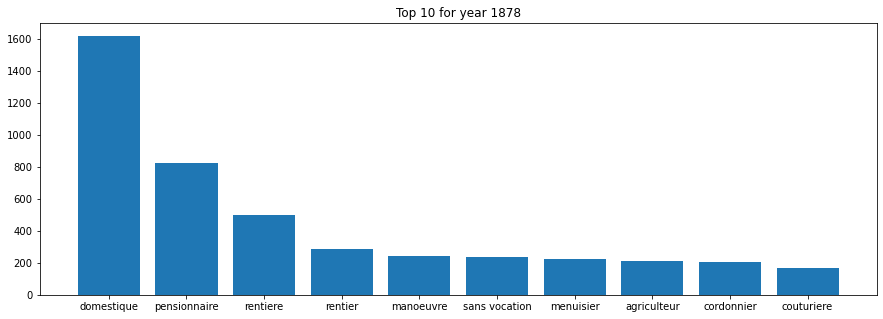

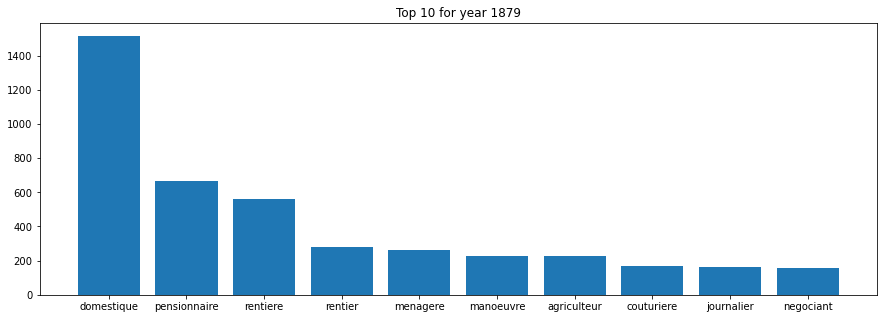

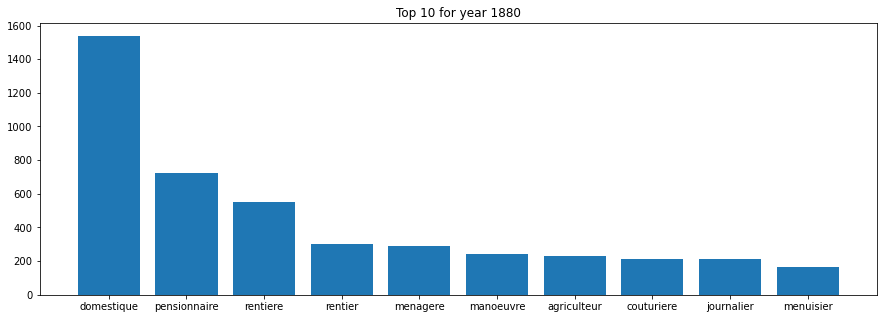

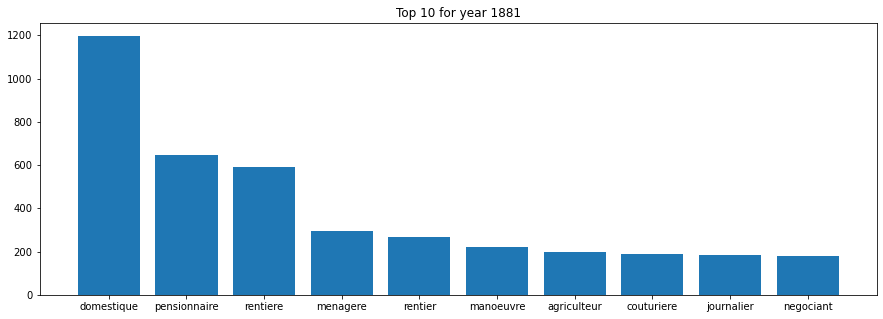

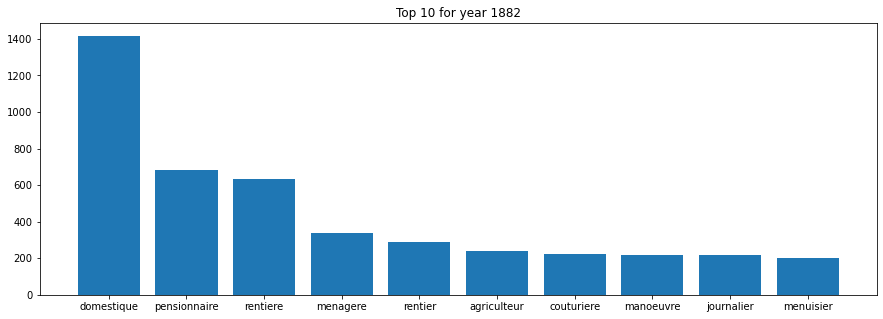

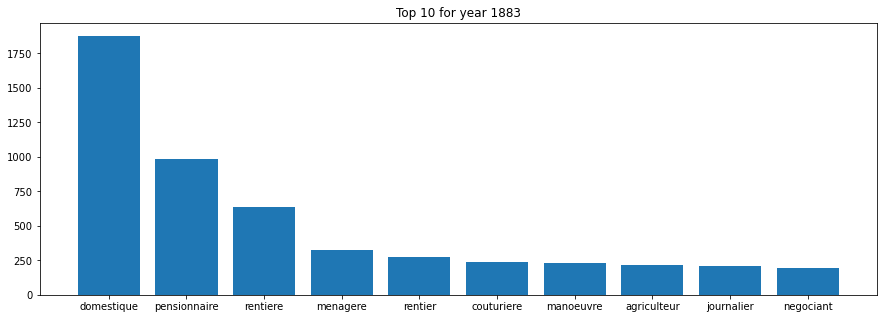

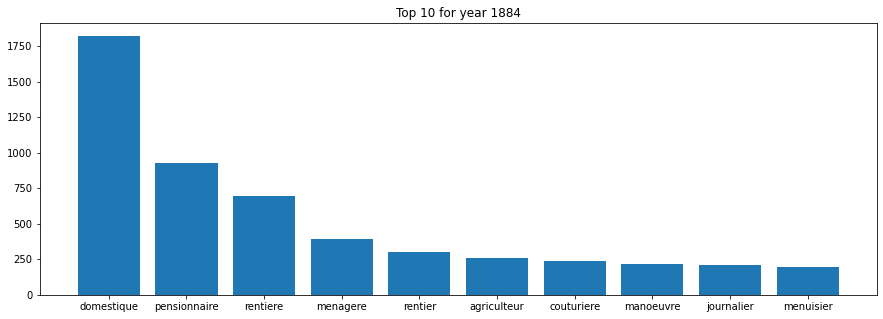

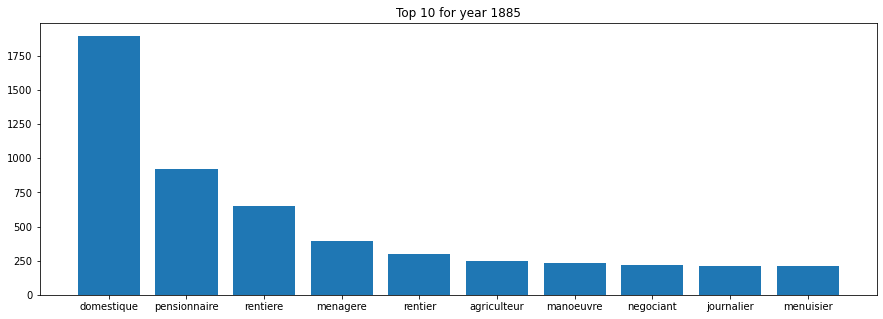

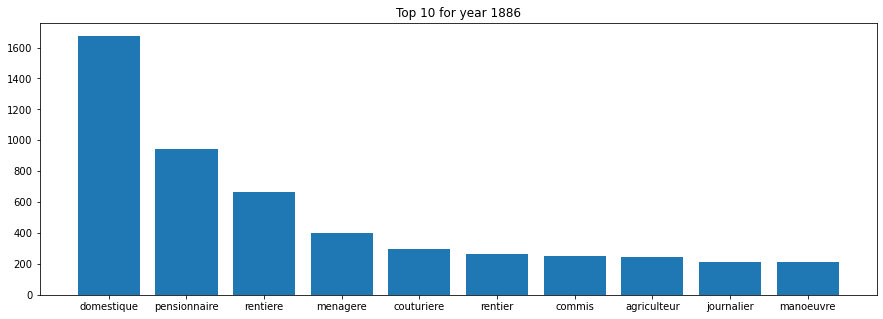

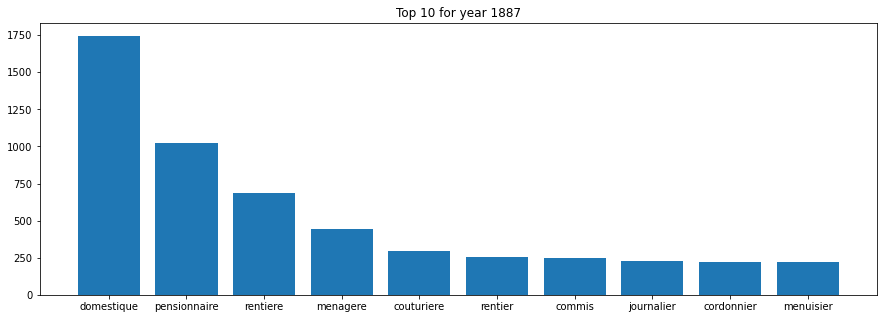

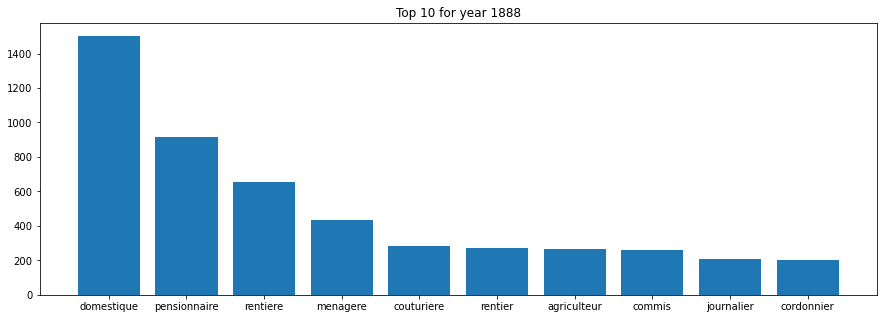

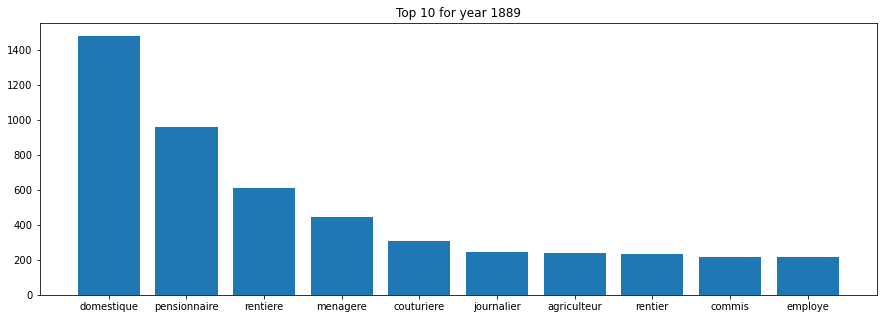

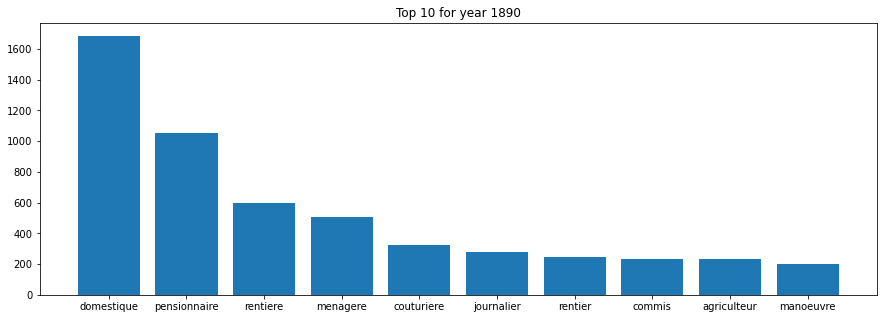

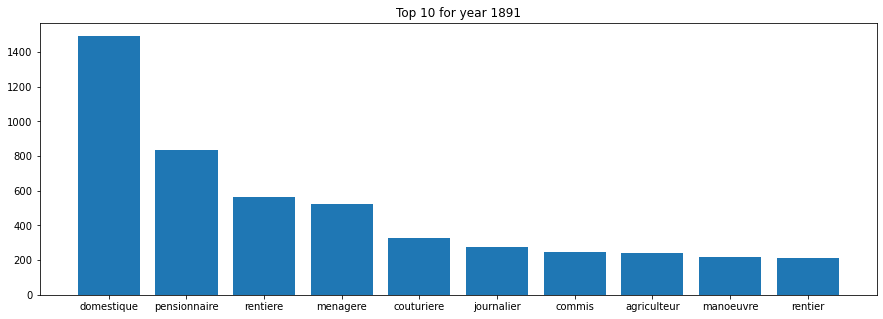

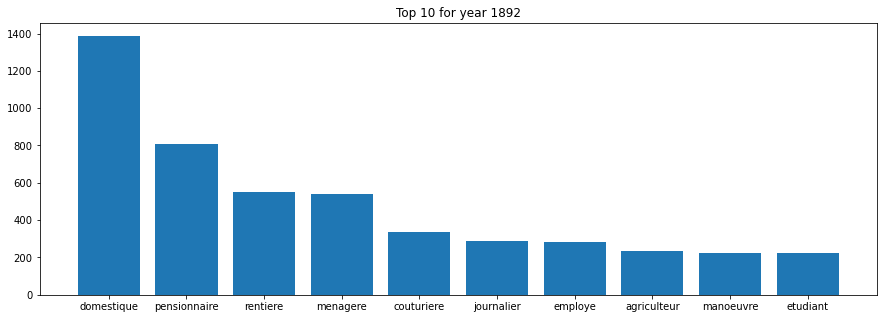

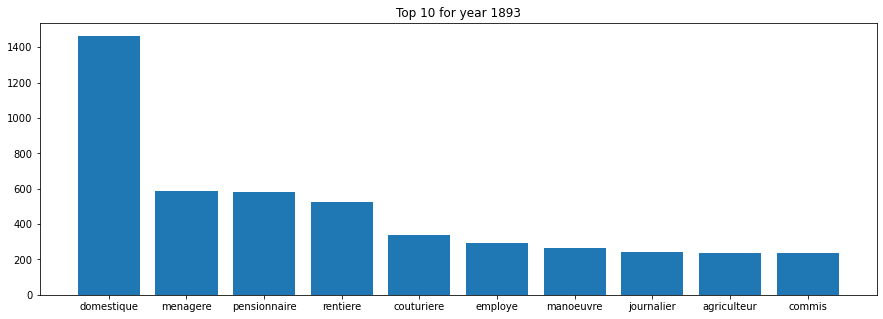

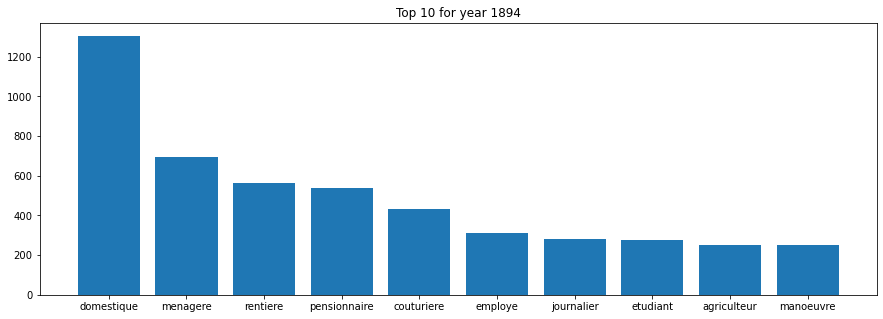

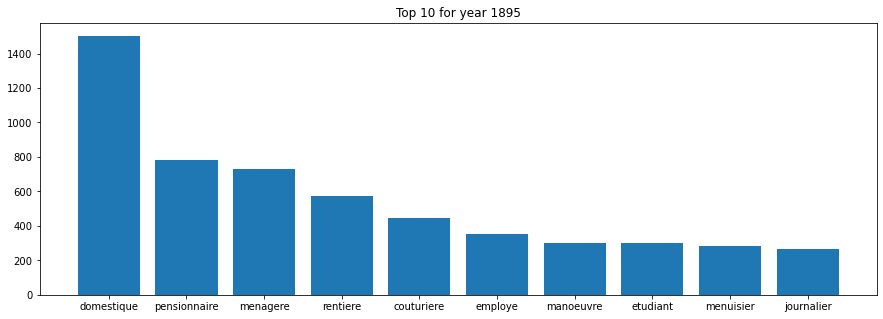

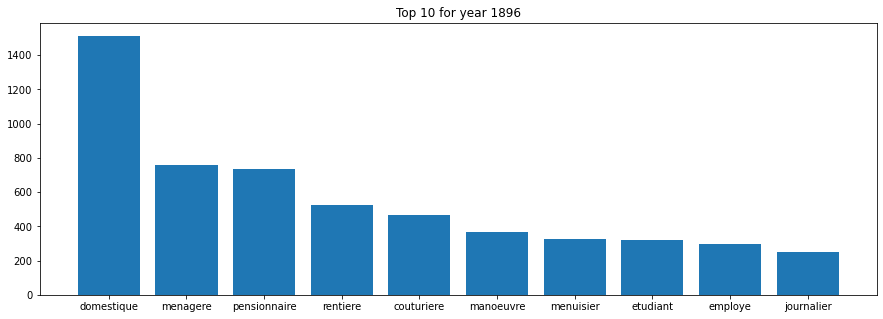

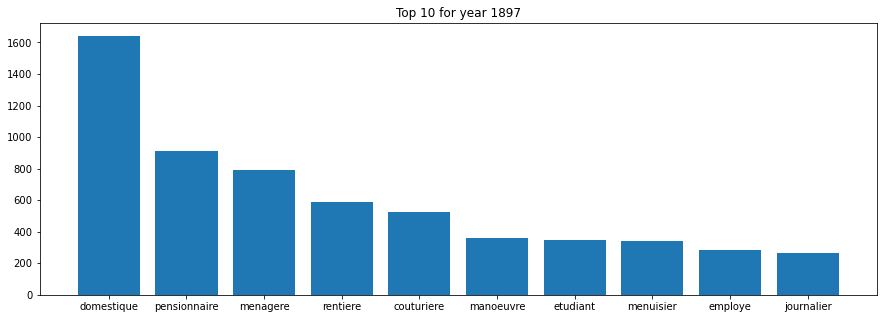

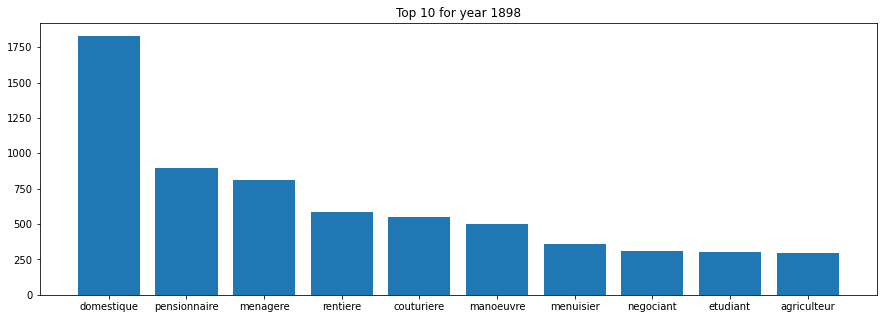

In [31]:
plot_top_job(df_selected_jobs_occ, "profession", 10, "top_job_year/")

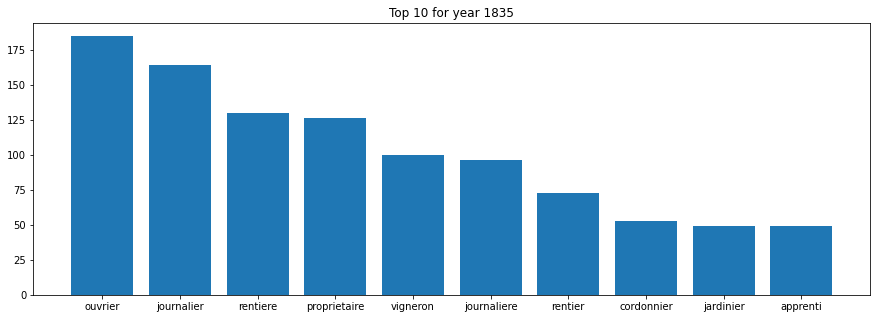

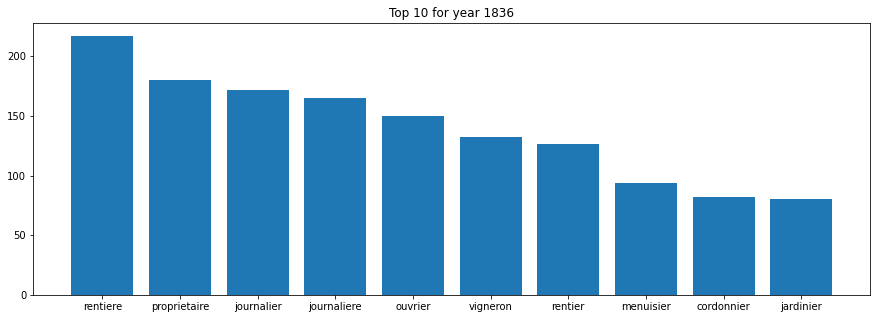

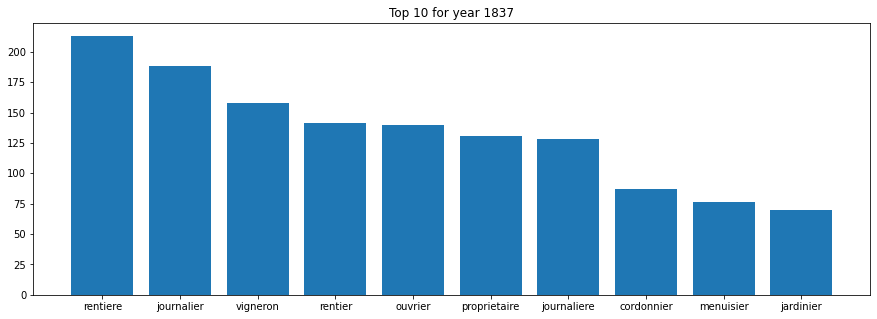

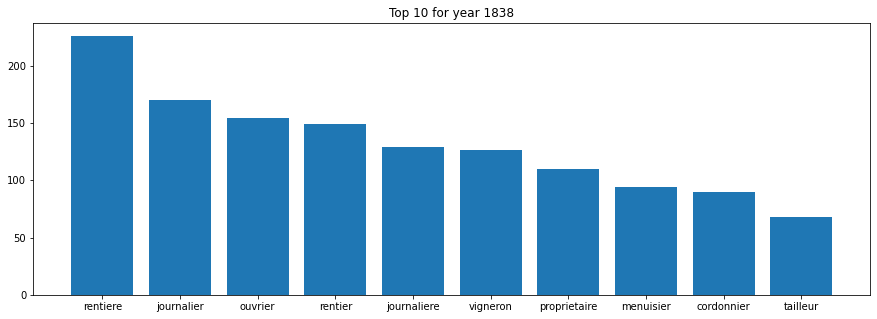

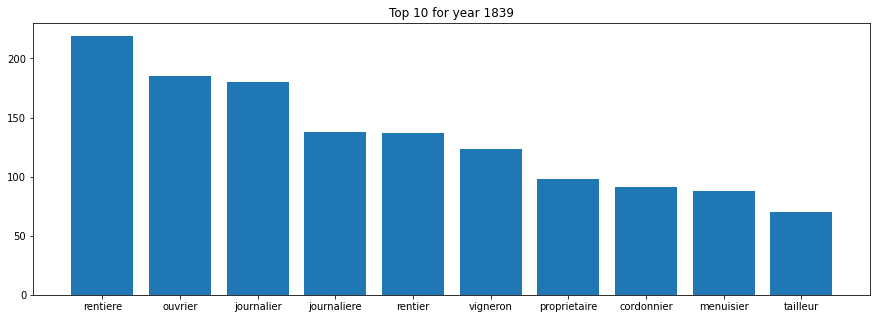

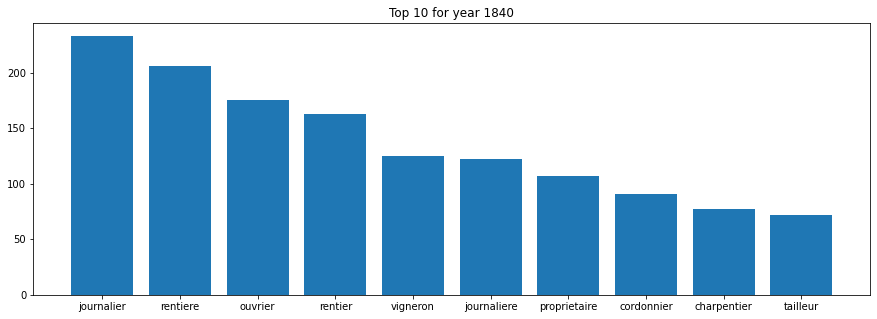

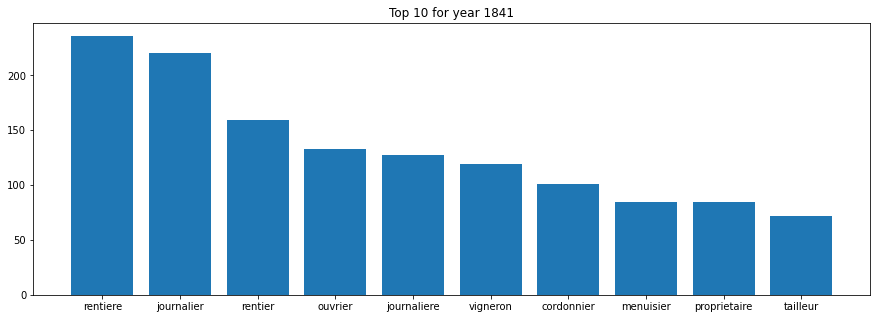

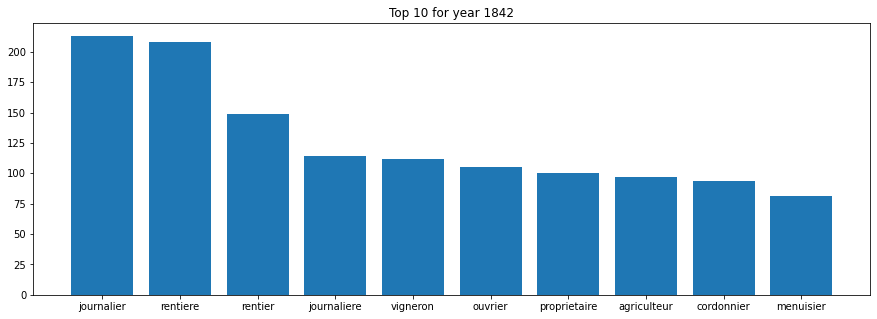

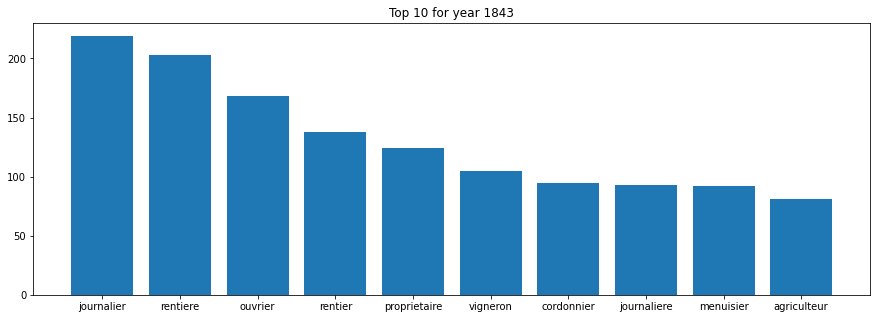

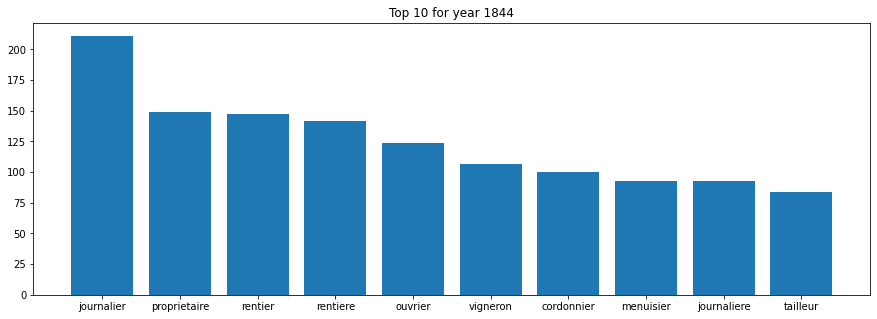

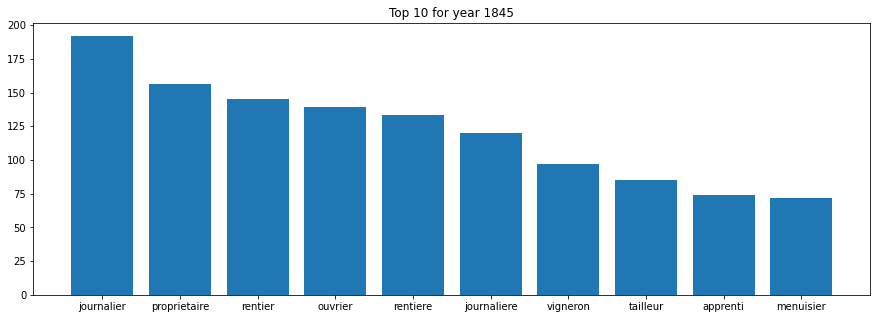

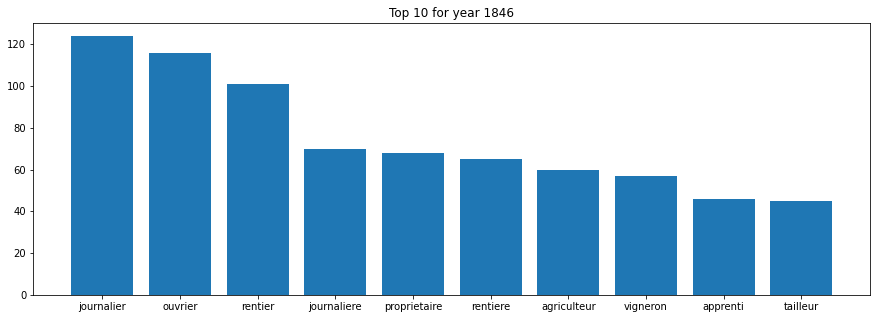

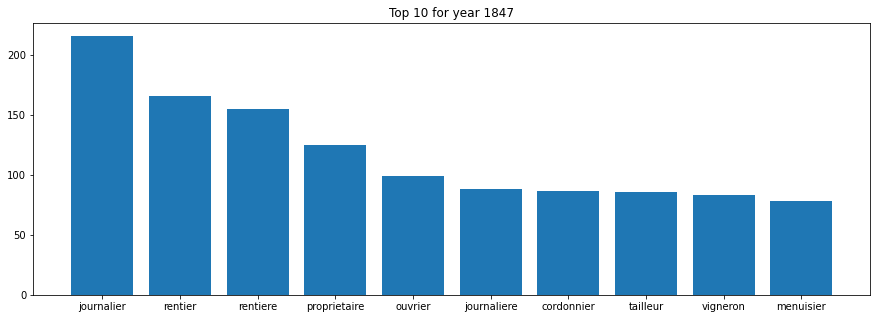

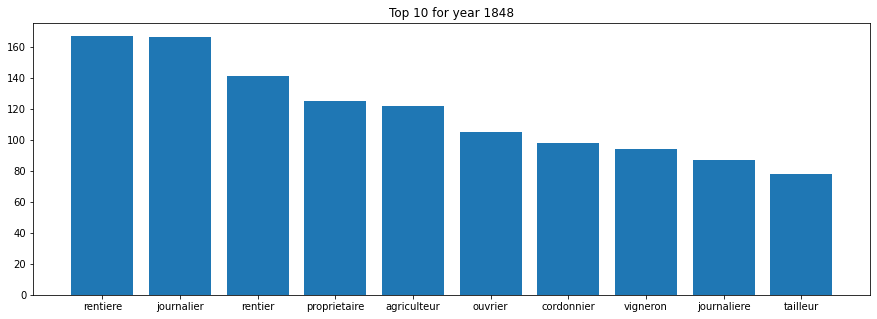

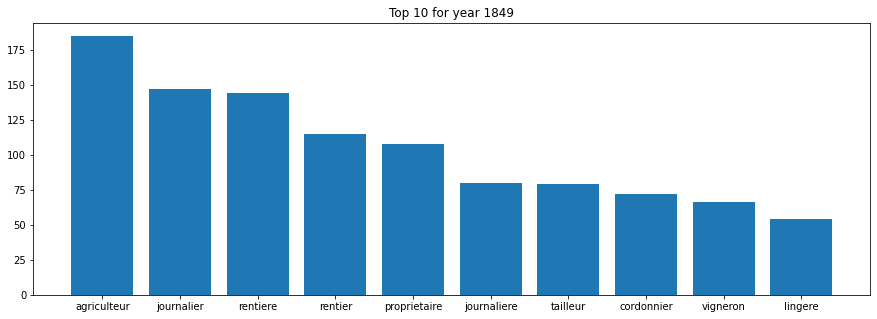

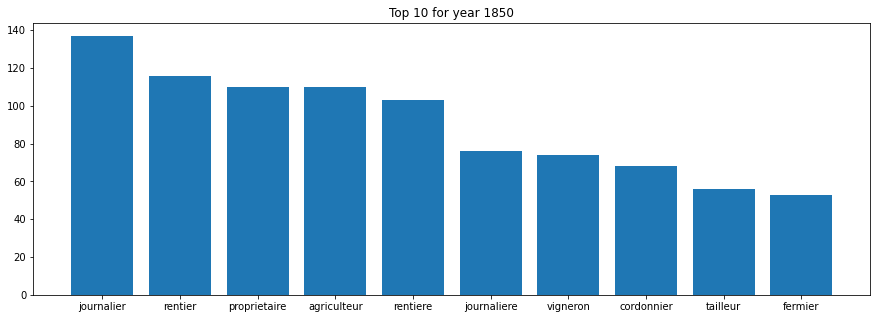

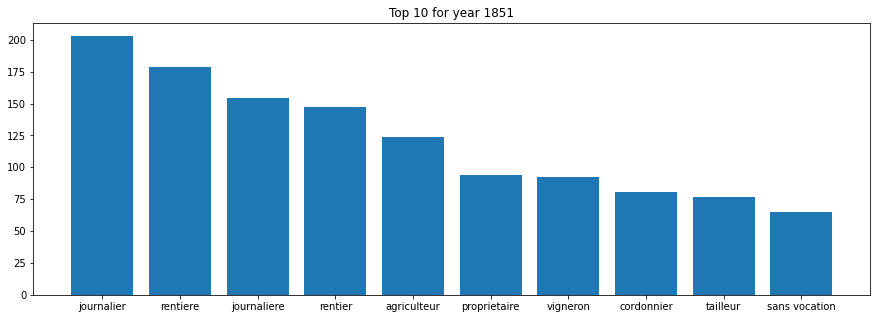

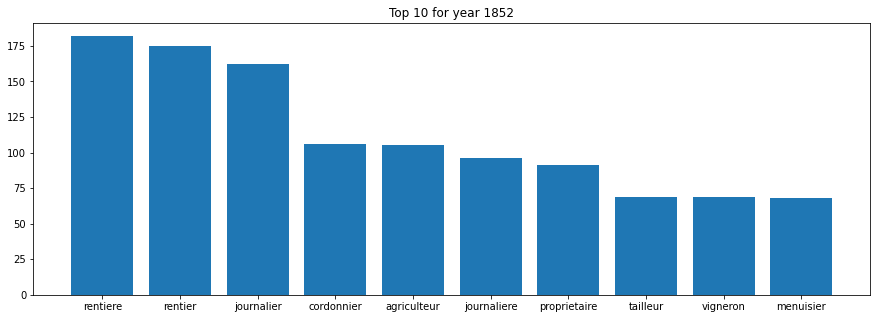

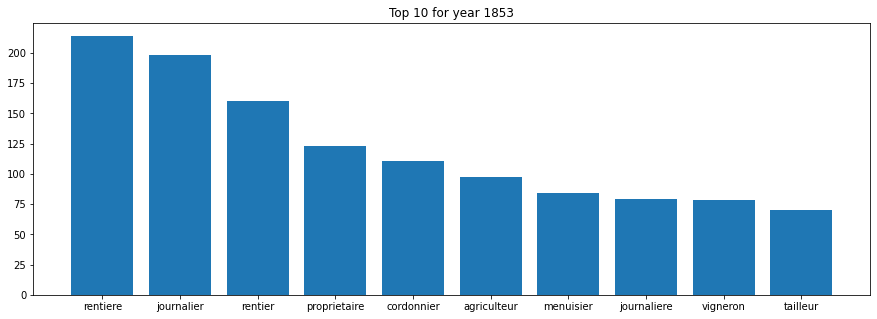

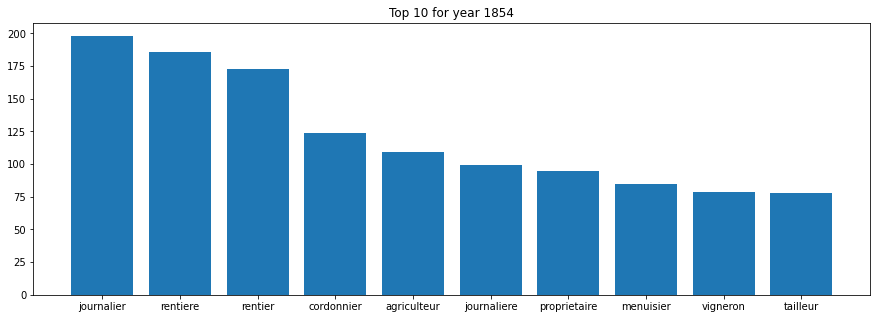

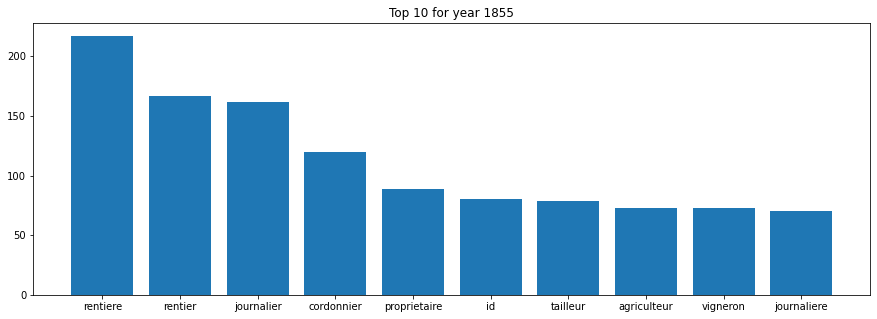

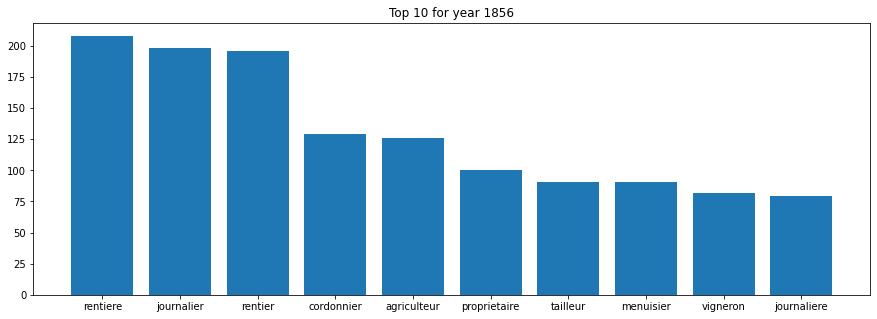

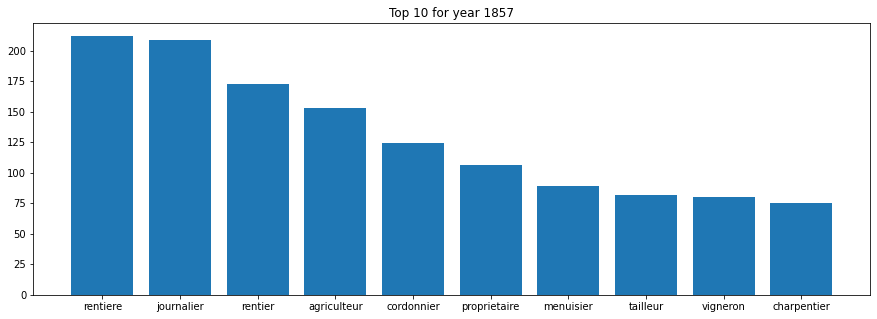

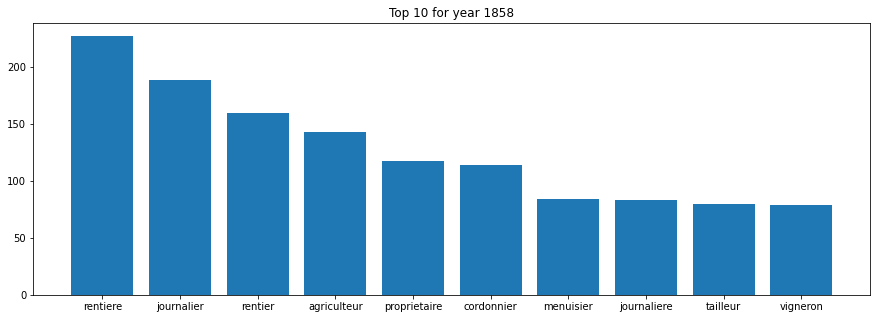

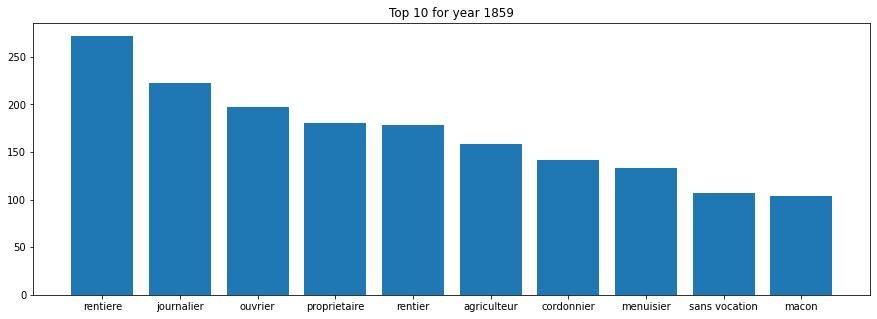

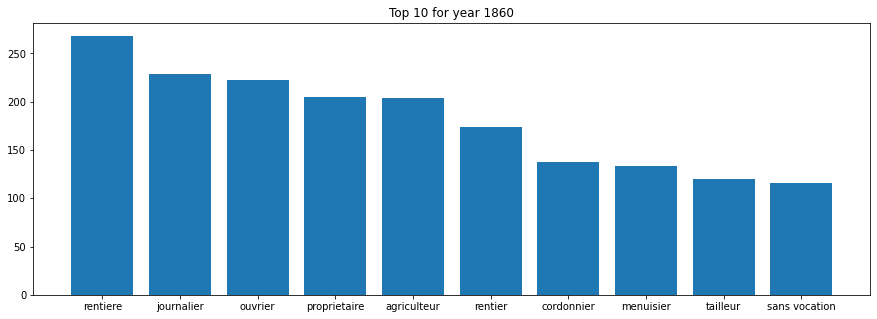

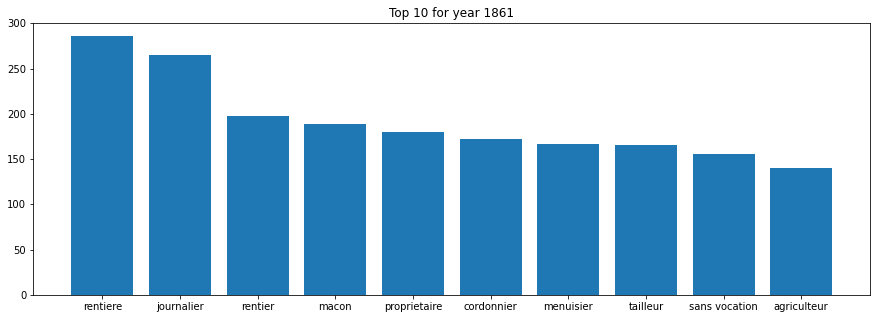

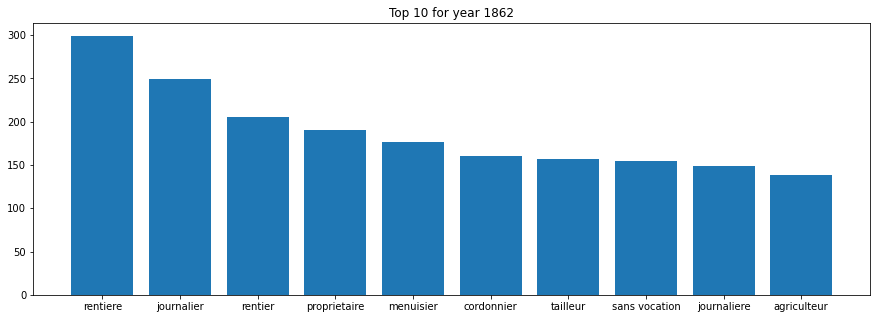

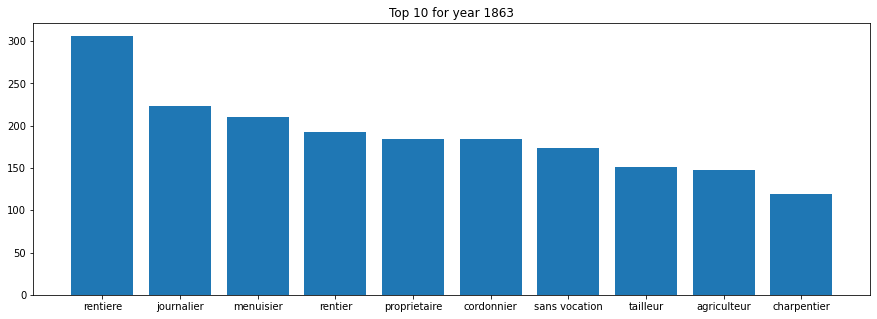

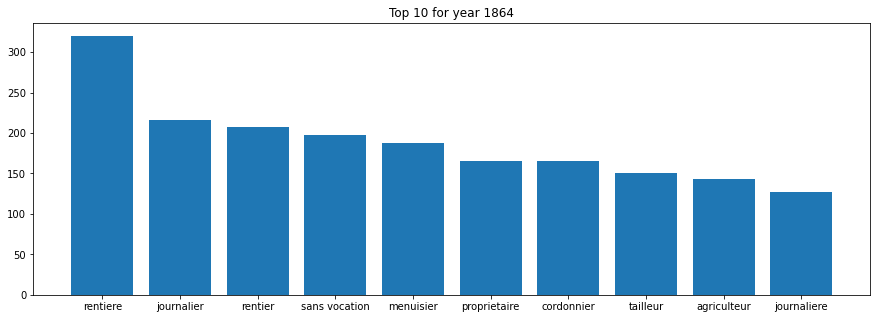

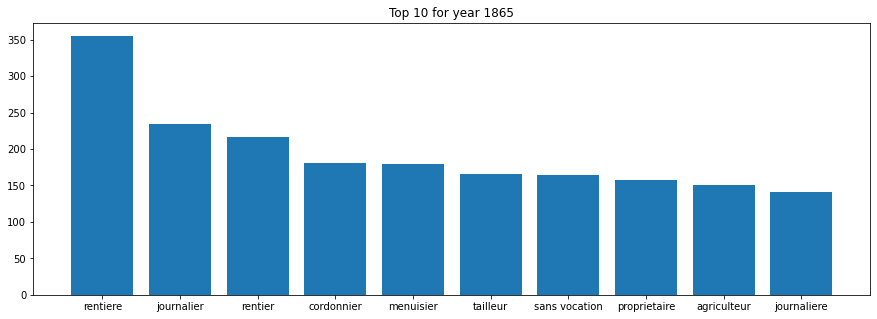

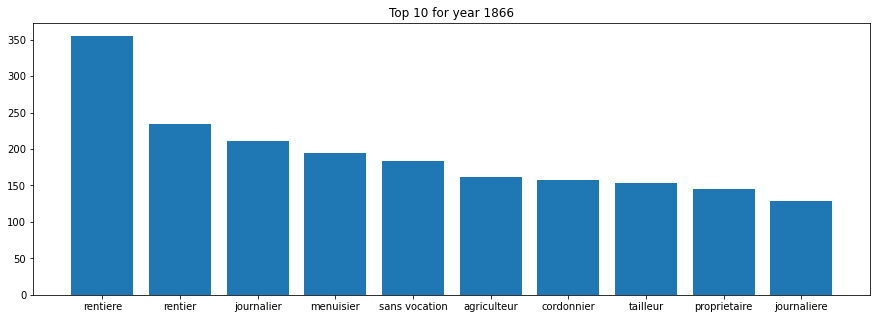

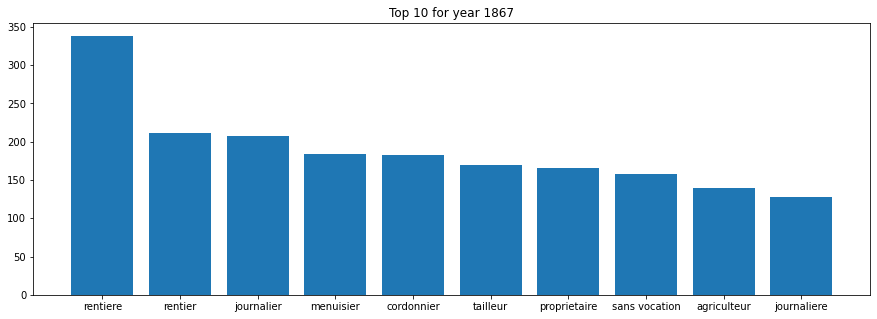

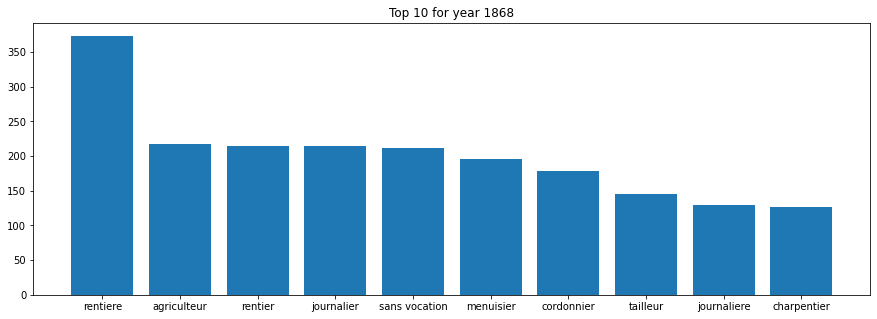

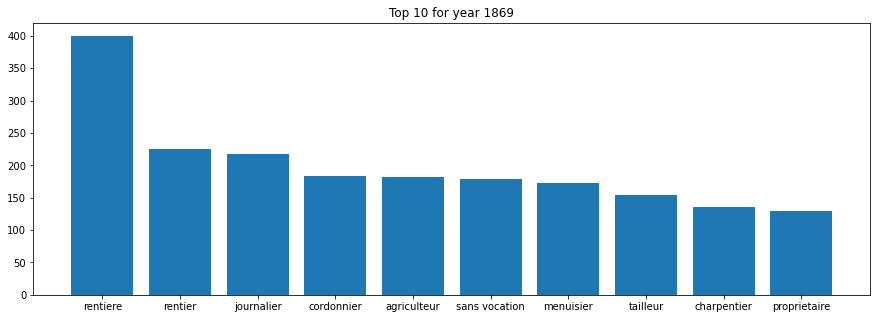

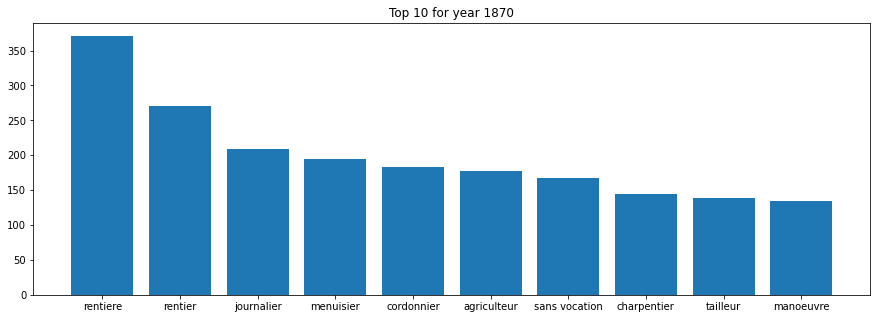

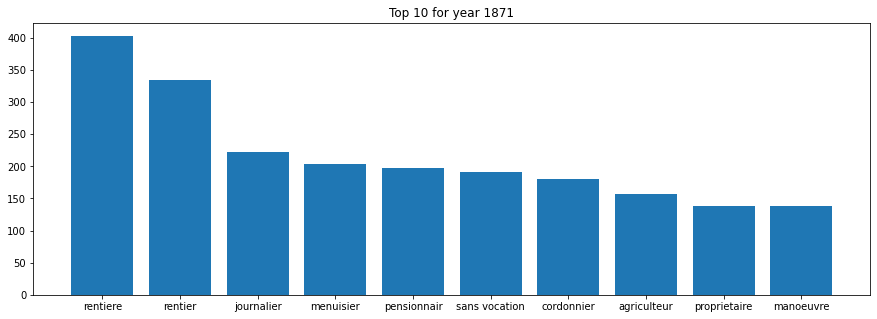

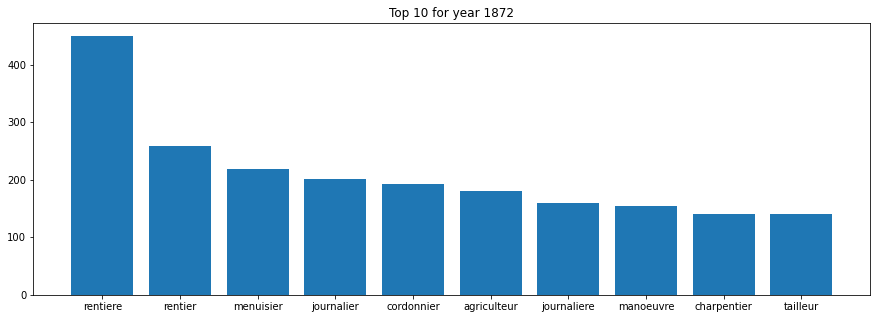

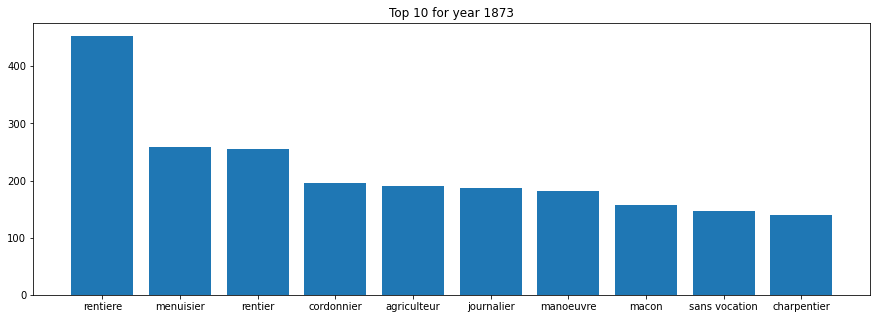

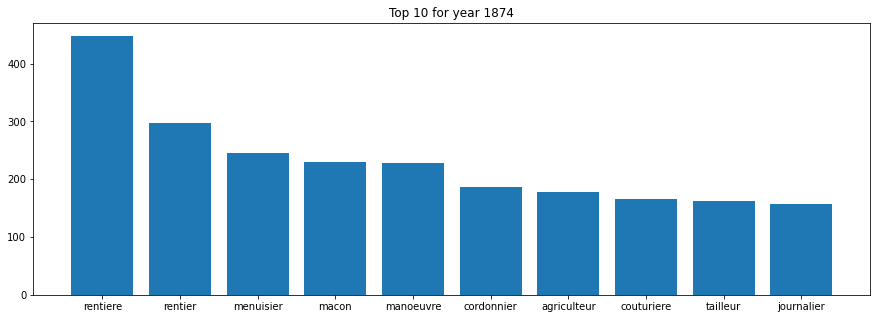

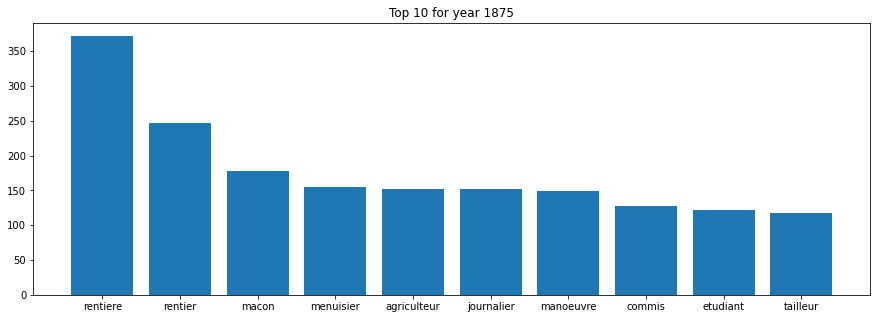

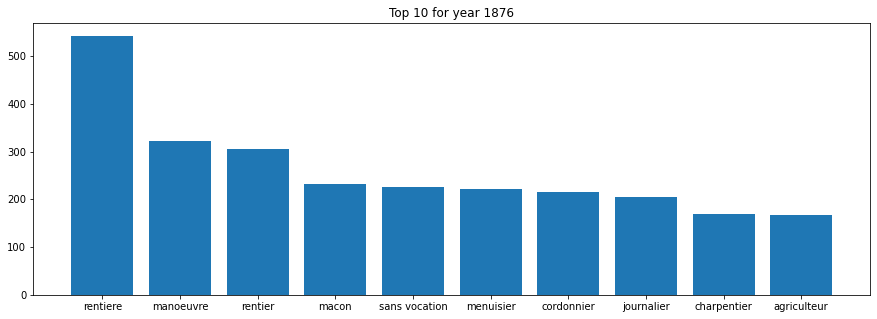

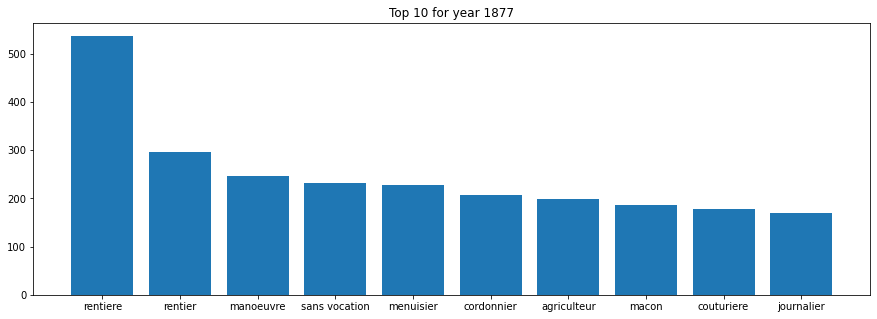

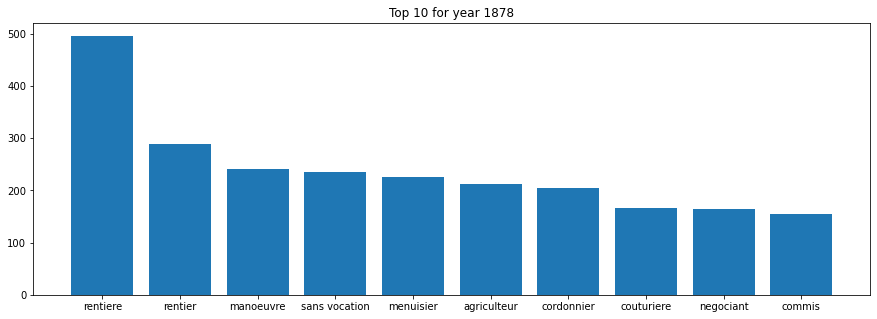

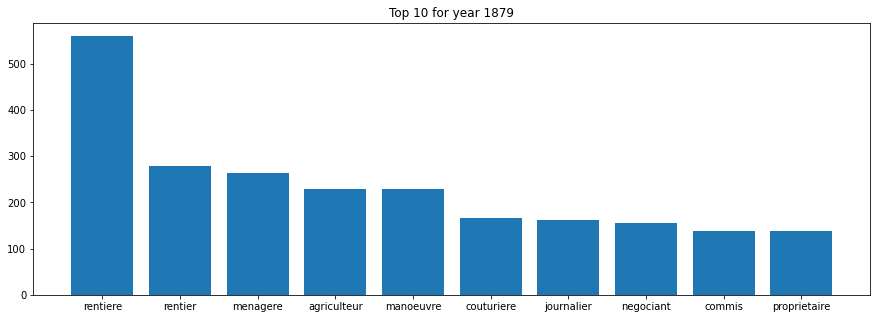

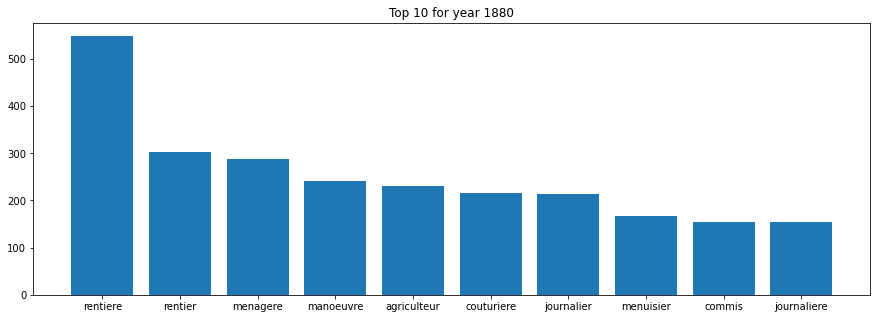

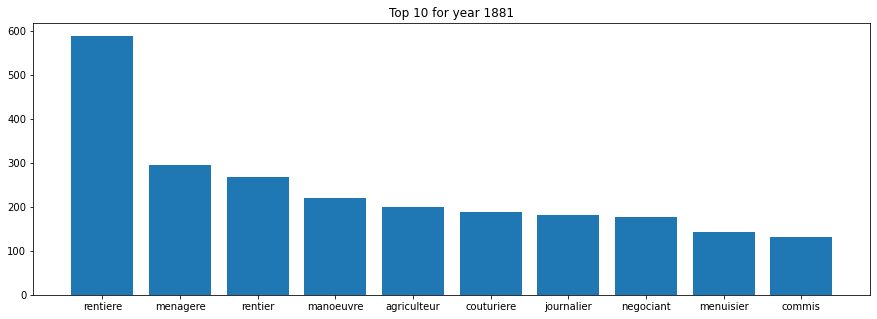

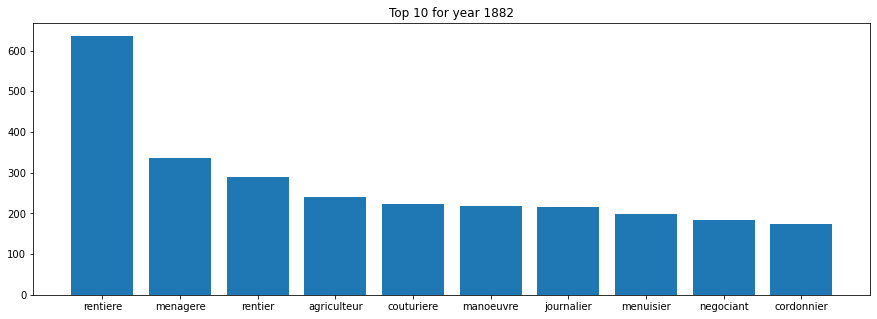

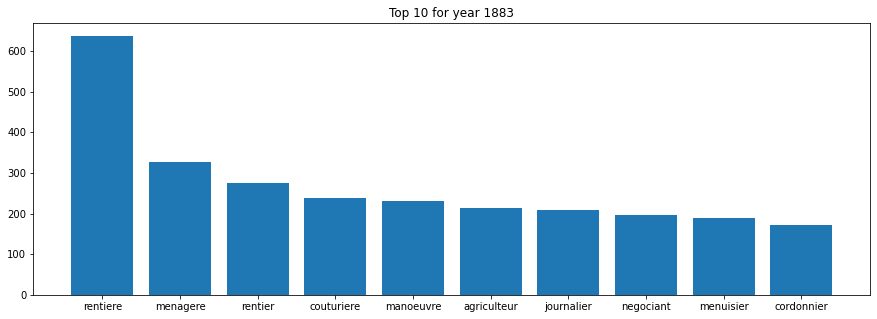

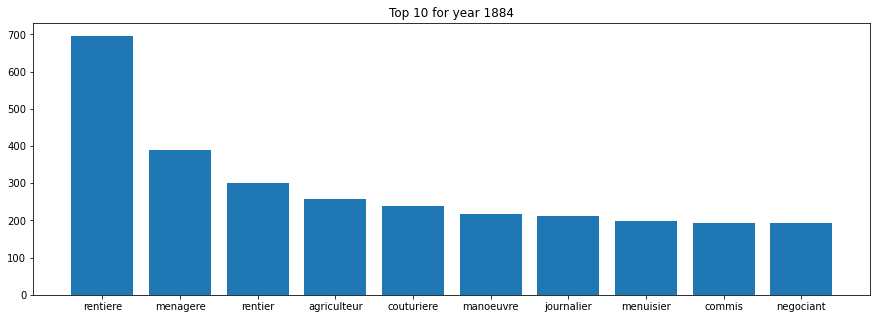

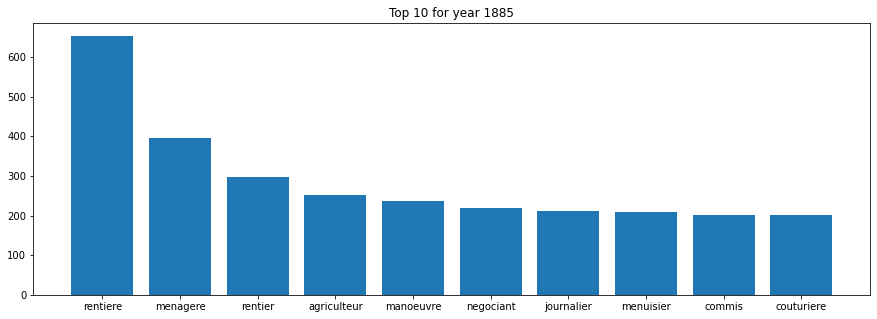

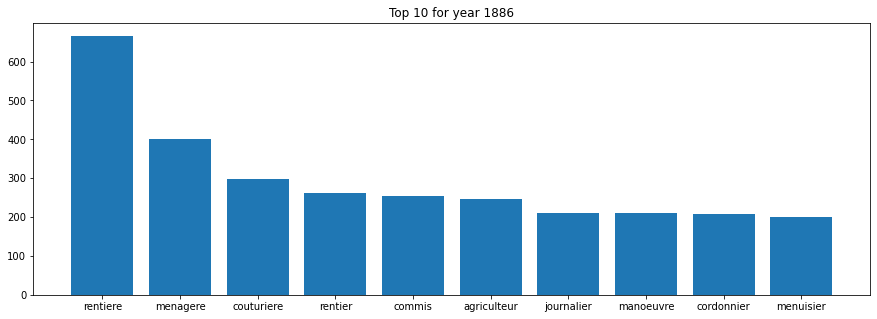

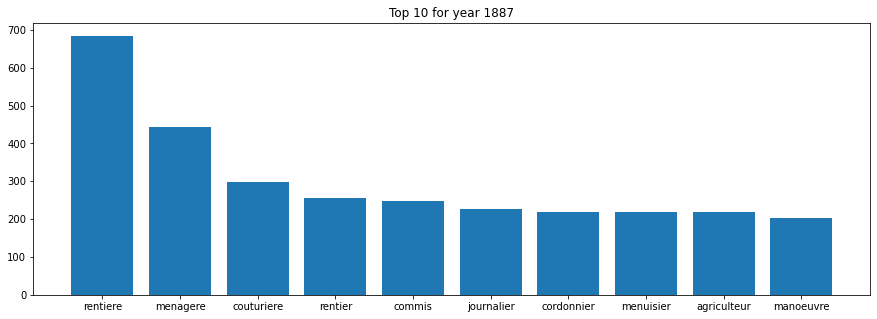

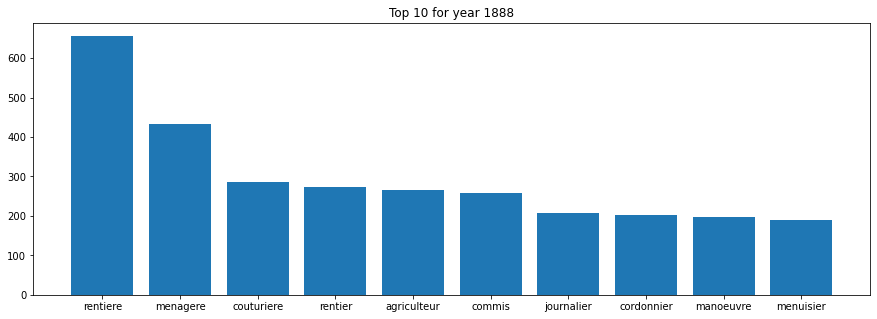

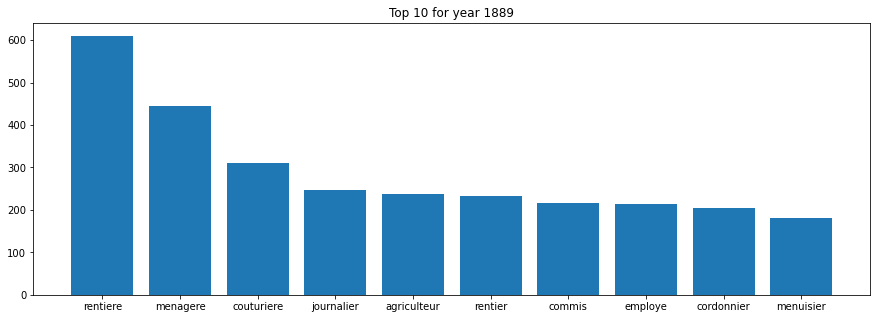

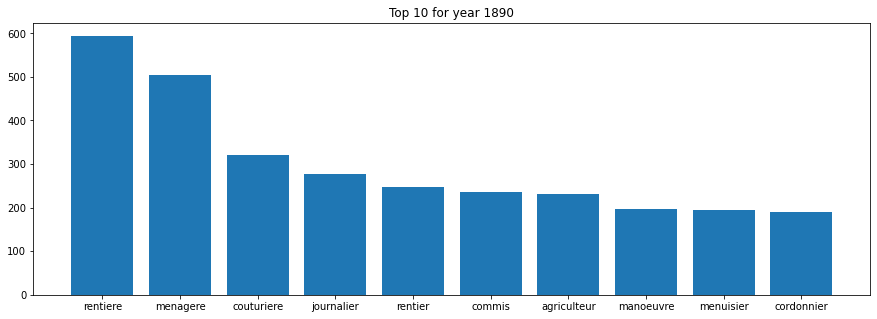

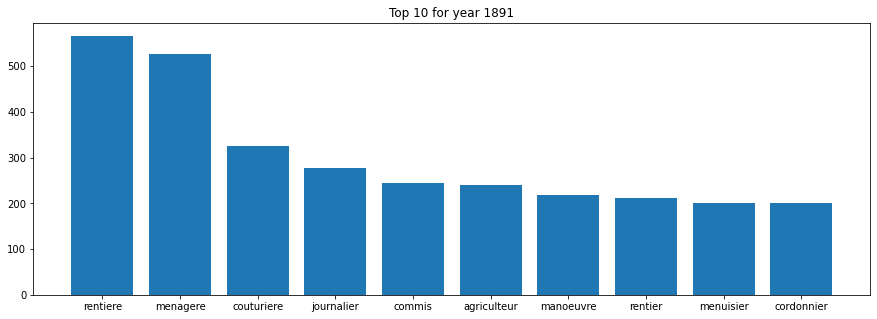

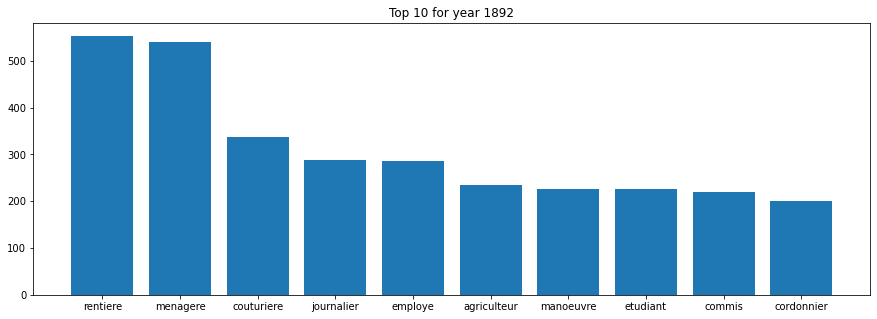

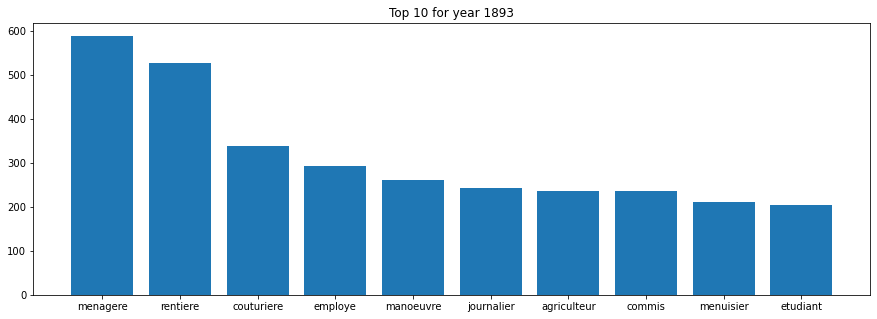

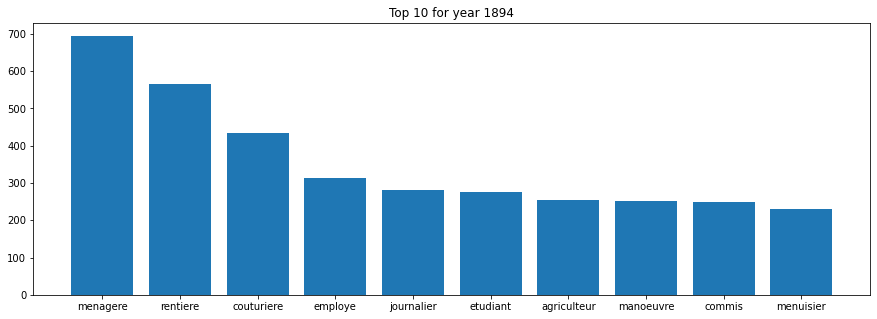

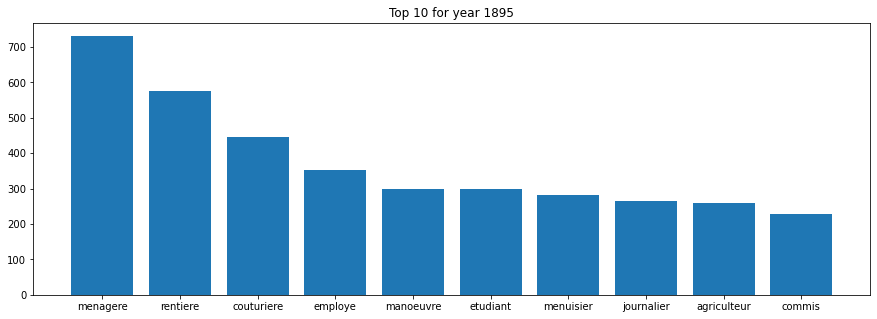

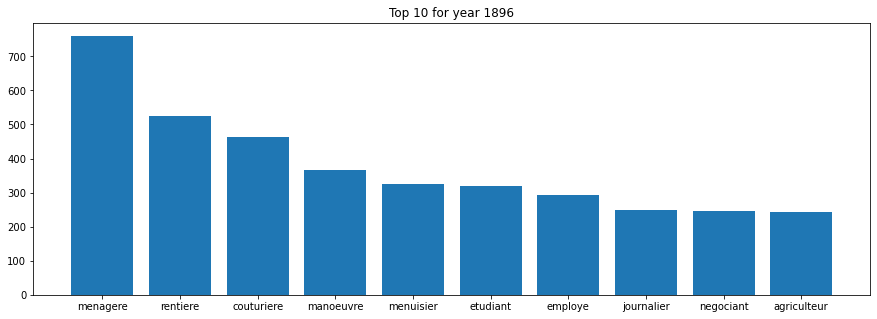

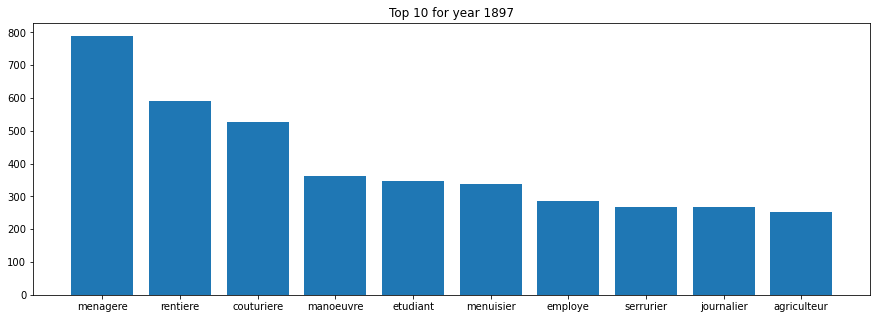

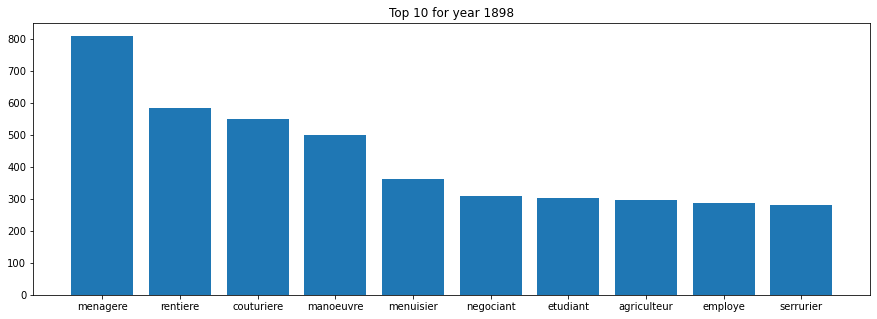

In [34]:
excluded_jobs = {"domestique", "pensionnaire"}
plot_top_job(df_selected_jobs_occ[~df_selected_jobs_occ["profession"].isin(excluded_jobs)], "profession", 10, "top_selected_job_year/")